In [141]:
%matplotlib notebook
#%matplotlib inline
import sys
sys.path.append("..")
import matplotlib.pyplot as plt
import os
import numpy as np
import json
import argparse
import torch
from torch.optim import lr_scheduler
from tqdm import tqdm
from data_loader import data_loaders as module_data
from model import loss as module_loss
from model import metric as module_metric
from model import model as module_arch
from trainer import Trainer
from utils import Logger
from utils import util
from utils import torchsummary
from utils import viewTraining
from utils import lr_finder
from utils import classActivationMap
import importlib
import math
import torchvision
from torch.nn import functional as F
from torch import topk
import skimage.transform
import jupyter
from IPython import display
from ipywidgets import *
print("Modules loaded")

importlib.reload(module_data) #load recent changes to data_loaders.py
importlib.reload(module_arch)
importlib.reload(module_loss)
importlib.reload(module_metric)
importlib.reload(util)
importlib.reload(viewTraining)
importlib.reload(lr_finder)
importlib.reload(classActivationMap)
print("Reload complete")

print("GPUs available: " + str(torch.cuda.device_count()))
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"




Modules loaded
Reload complete
GPUs available: 1


In [11]:
%%javascript
Jupyter.keyboard_manager.disable();
//System.out.println("disabled");
//Jupyter.keyboard_manager.command_shortcuts.remove_shortcut('j');
//System.out.println("remove j");
//Jupyter.keyboard_manager.command_shortcuts.remove_shortcut('k');
//System.out.println("remove k");

<IPython.core.display.Javascript object>

Total number of training images = 3461


<IPython.core.display.Javascript object>


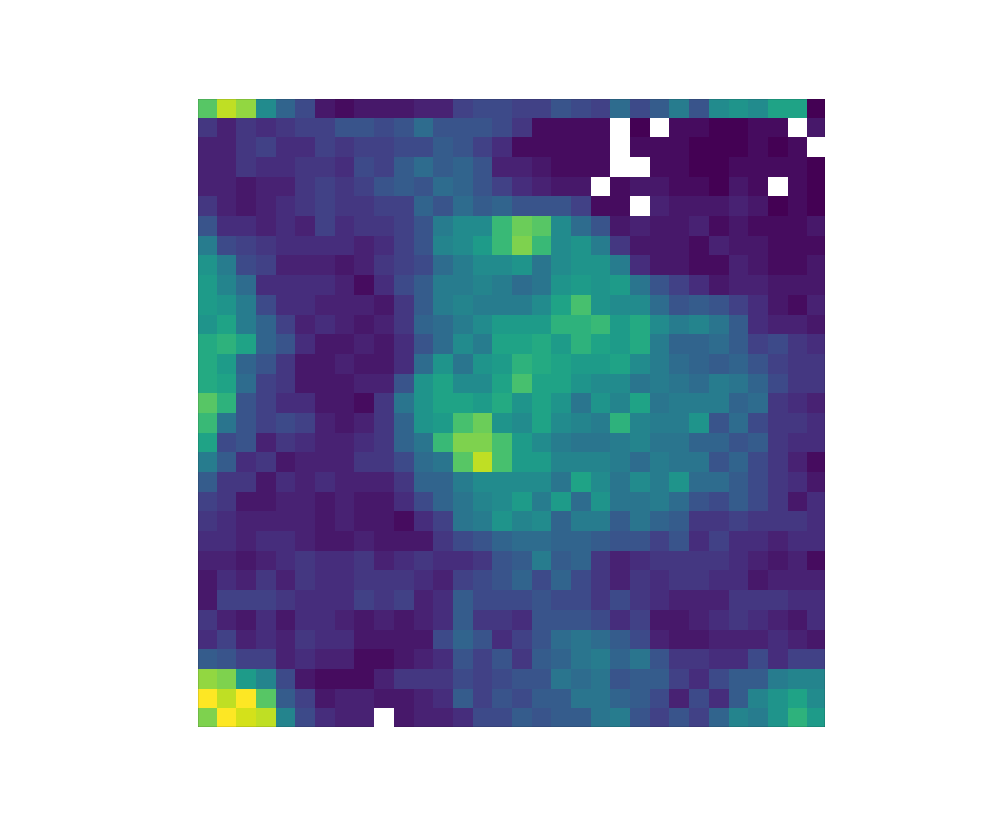

interactive(children=(IntSlider(value=0, description='layer', max=6), Output()), _dom_classes=('widget-interac…

In [152]:
#This function gets the parameters from the config.json file 
def get_instance(module, name, config, *args):
    return getattr(module, config[name]['type'])(*args, **config[name]['args'])

data_loader = get_instance(module_data, 'data_loader', config) #looks in data_loader/data_loaders.py for 'MNISTDataLoader'
print("Total number of training images = " + str(data_loader.dataset.data_len))
valid_data_loader = data_loader.split_validation() #allocate some images as validation

normalized = False
util.visualizeBatch(data_loader, normalized) 

In [151]:
#This function gets the parameters from the config.json file 
def get_instance(module, name, config, *args):
    return getattr(module, config[name]['type'])(*args, **config[name]['args'])

def set_instance(module, name, config, *args):
    setattr(module, config[name]['type'])(*args, **config[name]['args'])

def main(config, resume):
    train_logger = Logger() #uses entries to store training performance metrics
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # setup data_loader instances
    data_loader = get_instance(module_data, 'data_loader', config) #looks in data_loader/data_loaders.py for 'MNISTDataLoader'
    print("Total number of training images = " + str(data_loader.dataset.data_len))
    valid_data_loader = data_loader.split_validation() #allocate some images as validation

    # build model architecture
    model = get_instance(module_arch, 'arch', config) #looks in the model/model.py for 'MnistModel', as specified by config
    print(model)
    torchsummary.summary(model, (1,7,32,32))
     
    
    if torch.cuda.is_available():
        print("Using GPU: " + torch.cuda.get_device_name(0))
    else:
        print("Using CPU to train")
    
    
    # get function handles of loss and metrics
    loss = getattr(module_loss, config['loss']) #looks in model/loss.py for criterion function specified in config
    criterion = loss(data_loader.dataset.weight.to(device)) # for imbalanced datasets
    metrics = [getattr(module_metric, met) for met in config['metrics']] #get all the metrics in model/metrics.py - default is accuracy and top 3 accuracy

    # build optimizer, learning rate scheduler. delete every lines containing lr_scheduler for disabling scheduler
    trainable_params = filter(lambda p: p.requires_grad, model.parameters()) #Number of training params
    optimizer = get_instance(torch.optim, 'optimizer', config, trainable_params)
    lr_scheduler = get_instance(torch.optim.lr_scheduler, 'lr_scheduler', config, optimizer)

    
    trainer = Trainer(model, criterion, metrics, optimizer,
                      resume=resume, #choose a previous epoch to start training from
                      config=config,
                      data_loader=data_loader,
                      valid_data_loader=valid_data_loader,
                      lr_scheduler=lr_scheduler,
                      train_logger=train_logger)
    
    
    findLR = False
    if findLR:
        #set lr = 1e-7 in config file 
        device_lr = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        lr_finder_training = lr_finder.LRFinder(model, optimizer, criterion, device=device_lr)
        lr_finder_training.range_test(data_loader, end_lr=1, num_iter=100, val_loader = valid_data_loader)
        lr_finder_training.plot(skip_start = 10, skip_end=5)
        # trim the first 10 and last 5 iteration from calculating loss (num_iter > skip_start + skip_end)
    else:
        trainer.train()
        a=1
    
 

In [143]:
config_file = '../configs/config_hdf5.json'

# load config file
with open(config_file) as handle:
    config = json.load(handle)
# setting path to save trained models and log files
path = os.path.join(config['trainer']['save_dir'], config['name'])

In [145]:
# Train the network
main(config, None)

Total number of training images = 3461
threeDmodel(
  (conv_layer1): Sequential(
    (0): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (4): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (conv_layer2): Sequential(
    (0): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (4): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, t

    epoch          : 1
    loss           : 1.655150242473768
    my_metric      : 0.33079386645962733
    f1             : 0.2956159519559379
    balanced_accuracy: 0.5338170491328768
    precision      : 0.699470997960416
    recall         : 0.33079386645962733
    val_loss       : 1.266745638847351
    val_my_metric  : 0.18325892857142856
    val_f1         : 0.057787033100607156
    val_balanced_accuracy: 0.5
    val_precision  : 0.034440519371811223
    val_recall     : 0.18325892857142856
Saving checkpoint: ../saved/IMPRS_hdf5_volume_AllDAPI_0701/0701_215654/checkpoint-epoch1.pth ...
Saving current best: model_best.pth ...
    epoch          : 2
    loss           : 1.511033576467763
    my_metric      : 0.38582104037267084
    f1             : 0.37243340690941873
    balanced_accuracy: 0.5773325709381191
    precision      : 0.764367741420611
    recall         : 0.38582104037267084
    val_loss       : 1.144578766822815
    val_my_metric  : 0.175
    val_f1         : 0.0891371

Model has not improved in -------------| 1 epochs


    epoch          : 4
    loss           : 1.3941779499468596
    my_metric      : 0.44288625776397517
    f1             : 0.44992199718551207
    balanced_accuracy: 0.6126397193334858
    precision      : 0.7856102055479401
    recall         : 0.44288625776397517
    val_loss       : 1.2728742122650147
    val_my_metric  : 0.4404017857142857
    val_f1         : 0.45621062446446403
    val_balanced_accuracy: 0.5977437160607425
    val_precision  : 0.7484763385894201
    val_recall     : 0.4404017857142857


Model has not improved in -------------| 2 epochs


    epoch          : 5
    loss           : 1.3028926745704983
    my_metric      : 0.45924452208419597
    f1             : 0.4696499612401532
    balanced_accuracy: 0.6215528844463654
    precision      : 0.7831115900034405
    recall         : 0.45924452208419597
    val_loss       : 1.147266924381256
    val_my_metric  : 0.4263392857142857
    val_f1         : 0.45168851559818685
    val_balanced_accuracy: 0.6347985347985348
    val_precision  : 0.8394951358900871
    val_recall     : 0.4263392857142857


Model has not improved in -------------| 3 epochs


    epoch          : 6
    loss           : 1.218396448570749
    my_metric      : 0.49388047791580403
    f1             : 0.5161294749877409
    balanced_accuracy: 0.630308358792669
    precision      : 0.7806381816686472
    recall         : 0.49388047791580403
    val_loss       : 0.9328753829002381
    val_my_metric  : 0.6017857142857143
    val_f1         : 0.6437651686357705
    val_balanced_accuracy: 0.7293292266030363
    val_precision  : 0.8491087213802533
    val_recall     : 0.6017857142857143
Saving checkpoint: ../saved/IMPRS_hdf5_volume_AllDAPI_0701/0701_215654/checkpoint-epoch6.pth ...
Saving current best: model_best.pth ...
    epoch          : 7
    loss           : 1.1587401809899702
    my_metric      : 0.5367171325051759
    f1             : 0.5605563632612691
    balanced_accuracy: 0.6670135477505845
    precision      : 0.7988388163413644
    recall         : 0.5367171325051759
    val_loss       : 0.9626139998435974
    val_my_metric  : 0.5841517857142857
    val

Model has not improved in -------------| 1 epochs


    epoch          : 8
    loss           : 1.1427621919175852
    my_metric      : 0.5724529848171153
    f1             : 0.5996619957966413
    balanced_accuracy: 0.6875650615150944
    precision      : 0.805598971986237
    recall         : 0.5724529848171153
    val_loss       : 0.9007205247879029
    val_my_metric  : 0.6189732142857143
    val_f1         : 0.6491787567844299
    val_balanced_accuracy: 0.7352282031716809
    val_precision  : 0.8449164386988276
    val_recall     : 0.6189732142857143
Saving checkpoint: ../saved/IMPRS_hdf5_volume_AllDAPI_0701/0701_215654/checkpoint-epoch8.pth ...
Saving current best: model_best.pth ...
    epoch          : 9
    loss           : 1.0569798402164294
    my_metric      : 0.6057356366459627
    f1             : 0.6345087973574933
    balanced_accuracy: 0.7059717914520687
    precision      : 0.8082845979689369
    recall         : 0.6057356366459627
    val_loss       : 0.8370670199394226
    val_my_metric  : 0.6881696428571429
    val_

Model has not improved in -------------| 1 epochs


    epoch          : 11
    loss           : 0.9737081553625024
    my_metric      : 0.6723872066942719
    f1             : 0.6990005738674089
    balanced_accuracy: 0.7429650720183496
    precision      : 0.8211506392137496
    recall         : 0.6723872066942719
    val_loss       : 0.7631905972957611
    val_my_metric  : 0.7834821428571429
    val_f1         : 0.8206000388536145
    val_balanced_accuracy: 0.7963700513851141
    val_precision  : 0.8911750642952411
    val_recall     : 0.7834821428571429
Saving checkpoint: ../saved/IMPRS_hdf5_volume_AllDAPI_0701/0701_215654/checkpoint-epoch11.pth ...
Saving current best: model_best.pth ...
    epoch          : 12
    loss           : 0.897920644801596
    my_metric      : 0.7158870341614907
    f1             : 0.7393375589121957
    balanced_accuracy: 0.759774130667573
    precision      : 0.8236602402474946
    recall         : 0.7158870341614907
    val_loss       : 0.4435430109500885
    val_my_metric  : 0.90625
    val_f1       

Model has not improved in -------------| 1 epochs


    epoch          : 14
    loss           : 0.8167855221292247
    my_metric      : 0.7457621635610766
    f1             : 0.7651005384679184
    balanced_accuracy: 0.766151174768254
    precision      : 0.8244004960098009
    recall         : 0.7457621635610766
    val_loss       : 0.523841780424118
    val_my_metric  : 0.9
    val_f1         : 0.9017922537368293
    val_balanced_accuracy: 0.8535310582748181
    val_precision  : 0.9052872670807453
    val_recall     : 0.9


Model has not improved in -------------| 2 epochs


    epoch          : 15
    loss           : 0.7721351968205493
    my_metric      : 0.7596995772946861
    f1             : 0.7772887168169291
    balanced_accuracy: 0.7763809560728729
    precision      : 0.8311100343338176
    recall         : 0.7596995772946861
    val_loss       : 0.7555312871932983
    val_my_metric  : 0.846875
    val_f1         : 0.8594349638047387
    val_balanced_accuracy: 0.853472893207688
    val_precision  : 0.8918153283668527
    val_recall     : 0.846875


Model has not improved in -------------| 3 epochs


    epoch          : 16
    loss           : 0.7323638382165328
    my_metric      : 0.7760416666666666
    f1             : 0.7916486446282345
    balanced_accuracy: 0.784316296551755
    precision      : 0.8362462405711414
    recall         : 0.7760416666666666
    val_loss       : 0.6658638834953308
    val_my_metric  : 0.8511160714285714
    val_f1         : 0.8715397114797531
    val_balanced_accuracy: 0.8428506241381589
    val_precision  : 0.9060460706945083
    val_recall     : 0.8511160714285714


Model has not improved in -------------| 4 epochs


    epoch          : 17
    loss           : 0.6807475699030835
    my_metric      : 0.8066231021394065
    f1             : 0.8178442671028531
    balanced_accuracy: 0.7950693334407777
    precision      : 0.8445971454759676
    recall         : 0.8066231021394065
    val_loss       : 0.8704839646816254
    val_my_metric  : 0.8734375
    val_f1         : 0.8833054078221492
    val_balanced_accuracy: 0.8720869203415209
    val_precision  : 0.9075760071223385
    val_recall     : 0.8734375


Model has not improved in -------------| 5 epochs


    epoch          : 18
    loss           : 0.6731163509514021
    my_metric      : 0.799123317805383
    f1             : 0.8106474801418788
    balanced_accuracy: 0.7855239670737637
    precision      : 0.8405185464331658
    recall         : 0.799123317805383
    val_loss       : 0.8974084079265594
    val_my_metric  : 0.84375
    val_f1         : 0.8558289548070974
    val_balanced_accuracy: 0.8440107927850026
    val_precision  : 0.8861670965131232
    val_recall     : 0.84375


Model has not improved in -------------| 6 epochs


    epoch          : 19
    loss           : 0.6404589829237565
    my_metric      : 0.8066123188405797
    f1             : 0.81597881952764
    balanced_accuracy: 0.7849610529867701
    precision      : 0.8373174726913628
    recall         : 0.8066123188405797
    val_loss       : 0.7821423351764679
    val_my_metric  : 0.8839285714285714
    val_f1         : 0.8898677391548582
    val_balanced_accuracy: 0.8645756217713622
    val_precision  : 0.90562473177801
    val_recall     : 0.8839285714285714


Model has not improved in -------------| 7 epochs


    epoch          : 20
    loss           : 0.6001022885675016
    my_metric      : 0.8266422964113181
    f1             : 0.8338119631820817
    balanced_accuracy: 0.8035760481131228
    precision      : 0.8519219603614161
    recall         : 0.8266422964113181
    val_loss       : 0.8530739307403564
    val_my_metric  : 0.871875
    val_f1         : 0.8814792644081939
    val_balanced_accuracy: 0.8583225042165055
    val_precision  : 0.9024327533293931
    val_recall     : 0.871875


Model has not improved in -------------| 8 epochs


    epoch          : 21
    loss           : 0.6022417091805002
    my_metric      : 0.8307507332643201
    f1             : 0.8346618377560051
    balanced_accuracy: 0.7856834080759542
    precision      : 0.8424341574621639
    recall         : 0.8307507332643201
    val_loss       : 0.4768171668052673
    val_my_metric  : 0.8948660714285713
    val_f1         : 0.8932658418309611
    val_balanced_accuracy: 0.8338436096054812
    val_precision  : 0.9004340243478565
    val_recall     : 0.8948660714285713


Model has not improved in -------------| 9 epochs


    epoch          : 22
    loss           : 0.5312415503937266
    my_metric      : 0.839544513457557
    f1             : 0.8432475978946898
    balanced_accuracy: 0.7951127631920347
    precision      : 0.8509478838515049
    recall         : 0.839544513457557
    val_loss       : 0.601162338256836
    val_my_metric  : 0.890625
    val_f1         : 0.8937000069188425
    val_balanced_accuracy: 0.8485331312011983
    val_precision  : 0.8987740388365111
    val_recall     : 0.890625


Model has not improved in -------------| 10 epochs


    epoch          : 23
    loss           : 0.5433359651461892
    my_metric      : 0.8388597739820566
    f1             : 0.8417651387932767
    balanced_accuracy: 0.7889366158007846
    precision      : 0.8484143826417939
    recall         : 0.8388597739820566
    val_loss       : 0.37784401774406434
    val_my_metric  : 0.8823660714285714
    val_f1         : 0.8619221363560616
    val_balanced_accuracy: 0.7048881426226964
    val_precision  : 0.8562254779819168
    val_recall     : 0.8823660714285714
Saving checkpoint: ../saved/IMPRS_hdf5_volume_AllDAPI_0701/0701_215654/checkpoint-epoch23.pth ...
Saving current best: model_best.pth ...
    epoch          : 24
    loss           : 0.5449537090633226
    my_metric      : 0.8378838854382332
    f1             : 0.8394085796304174
    balanced_accuracy: 0.780243765382701
    precision      : 0.8448058381354686
    recall         : 0.8378838854382332
    val_loss       : 0.6098235368728637
    val_my_metric  : 0.8651785714285714
    

Model has not improved in -------------| 1 epochs


    epoch          : 25
    loss           : 0.5208450095809024
    my_metric      : 0.8375388198757764
    f1             : 0.8388646029713883
    balanced_accuracy: 0.7744980262125718
    precision      : 0.8432081066827395
    recall         : 0.8375388198757764
    val_loss       : 0.27651728987693786
    val_my_metric  : 0.90625
    val_f1         : 0.8946249959825312
    val_balanced_accuracy: 0.777423015157569
    val_precision  : 0.9058848195198468
    val_recall     : 0.90625
Saving checkpoint: ../saved/IMPRS_hdf5_volume_AllDAPI_0701/0701_215654/checkpoint-epoch25.pth ...
Saving current best: model_best.pth ...
    epoch          : 26
    loss           : 0.4476861863032631
    my_metric      : 0.8514600586611456
    f1             : 0.8510413766112999
    balanced_accuracy: 0.7845878724549749
    precision      : 0.8527161915981128
    recall         : 0.8514600586611456
    val_loss       : 0.5324279248714447
    val_my_metric  : 0.909375
    val_f1         : 0.9127449029326

Model has not improved in -------------| 1 epochs


    epoch          : 27
    loss           : 0.4918099188286325
    my_metric      : 0.8477344289164941
    f1             : 0.8461565893501456
    balanced_accuracy: 0.7728509393070987
    precision      : 0.8508375665722234
    recall         : 0.8477344289164941
    val_loss       : 0.4408604323863983
    val_my_metric  : 0.8361607142857143
    val_f1         : 0.8233508236669591
    val_balanced_accuracy: 0.7305251009815087
    val_precision  : 0.8147513708732392
    val_recall     : 0.8361607142857143


Model has not improved in -------------| 2 epochs


    epoch          : 28
    loss           : 0.4527912852556809
    my_metric      : 0.8504895617667357
    f1             : 0.8486064192550064
    balanced_accuracy: 0.7742456211657113
    precision      : 0.8508509684639826
    recall         : 0.8504895617667357
    val_loss       : 0.28025113344192504
    val_my_metric  : 0.903125
    val_f1         : 0.893329950328513
    val_balanced_accuracy: 0.7868623326432576
    val_precision  : 0.9008036946321141
    val_recall     : 0.903125


Model has not improved in -------------| 3 epochs


    epoch          : 29
    loss           : 0.46670281757479126
    my_metric      : 0.848413776742581
    f1             : 0.8463483293220435
    balanced_accuracy: 0.7748769526548343
    precision      : 0.848096214919802
    recall         : 0.848413776742581
    val_loss       : 0.3270436018705368
    val_my_metric  : 0.9203125
    val_f1         : 0.9157544723653357
    val_balanced_accuracy: 0.831579064506623
    val_precision  : 0.9172807348432037
    val_recall     : 0.9203125


Model has not improved in -------------| 4 epochs


    epoch          : 30
    loss           : 0.45585323675819067
    my_metric      : 0.8616394927536232
    f1             : 0.8585592393699923
    balanced_accuracy: 0.787339940410958
    precision      : 0.8607049586724815
    recall         : 0.8616394927536232
    val_loss       : 0.735001140832901
    val_my_metric  : 0.8475446428571429
    val_f1         : 0.8387474349073786
    val_balanced_accuracy: 0.6812923798281855
    val_precision  : 0.8454949223104794
    val_recall     : 0.8475446428571429


Model has not improved in -------------| 5 epochs


    epoch          : 31
    loss           : 0.42556203318678815
    my_metric      : 0.8589382763975155
    f1             : 0.8547042409067747
    balanced_accuracy: 0.7736123287139783
    precision      : 0.8553200496633098
    recall         : 0.8589382763975155
    val_loss       : 0.445634064078331
    val_my_metric  : 0.921875
    val_f1         : 0.9196079908656122
    val_balanced_accuracy: 0.8523849456622565
    val_precision  : 0.9195018853669417
    val_recall     : 0.921875


Model has not improved in -------------| 6 epochs


    epoch          : 32
    loss           : 0.4115540041871693
    my_metric      : 0.8555415372670808
    f1             : 0.8507452882111426
    balanced_accuracy: 0.7711047200471048
    precision      : 0.8532581055981987
    recall         : 0.8555415372670808
    val_loss       : 0.2442487061023712
    val_my_metric  : 0.9125
    val_f1         : 0.9041331970106317
    val_balanced_accuracy: 0.8012492954243002
    val_precision  : 0.9105738100467186
    val_recall     : 0.9125
Saving checkpoint: ../saved/IMPRS_hdf5_volume_AllDAPI_0701/0701_215654/checkpoint-epoch32.pth ...
Saving current best: model_best.pth ...
    epoch          : 33
    loss           : 0.43064781505128613
    my_metric      : 0.8555361456176673
    f1             : 0.8497484257739945
    balanced_accuracy: 0.7598059335446791
    precision      : 0.8518331895297109
    recall         : 0.8555361456176673
    val_loss       : 0.24665014147758485
    val_my_metric  : 0.8017857142857142
    val_f1         : 0.746

Model has not improved in -------------| 1 epochs


    epoch          : 34
    loss           : 0.37306937251401984
    my_metric      : 0.851120384748102
    f1             : 0.8458681936007876
    balanced_accuracy: 0.7619166413598384
    precision      : 0.8465170975885157
    recall         : 0.851120384748102
    val_loss       : 0.4675534933805466
    val_my_metric  : 0.9140625
    val_f1         : 0.9146399280788268
    val_balanced_accuracy: 0.8717379398108778
    val_precision  : 0.9161344691370827
    val_recall     : 0.9140625


Model has not improved in -------------| 2 epochs


    epoch          : 35
    loss           : 0.38260510175124457
    my_metric      : 0.8558973861283643
    f1             : 0.8492463800987287
    balanced_accuracy: 0.7574568142437762
    precision      : 0.8511553562171971
    recall         : 0.8558973861283643
    val_loss       : 0.8069049894809723
    val_my_metric  : 0.8839285714285714
    val_f1         : 0.8832775163603286
    val_balanced_accuracy: 0.8193357233273361
    val_precision  : 0.8917071053763772
    val_recall     : 0.8839285714285714


Model has not improved in -------------| 3 epochs


    epoch          : 36
    loss           : 0.35311226417189057
    my_metric      : 0.8657425379572119
    f1             : 0.8581461993241145
    balanced_accuracy: 0.7634805962221469
    precision      : 0.8621314040360433
    recall         : 0.8657425379572119
    val_loss       : 0.434796479344368
    val_my_metric  : 0.8756696428571429
    val_f1         : 0.8655412865071185
    val_balanced_accuracy: 0.8080953292016572
    val_precision  : 0.892723056421137
    val_recall     : 0.8756696428571429


Model has not improved in -------------| 4 epochs


    epoch          : 37
    loss           : 0.3709418929141501
    my_metric      : 0.8640118184955142
    f1             : 0.856907128494334
    balanced_accuracy: 0.7672288195430275
    precision      : 0.8623368968247855
    recall         : 0.8640118184955142
    val_loss       : 0.37917502224445343
    val_my_metric  : 0.8647321428571428
    val_f1         : 0.8384269561107429
    val_balanced_accuracy: 0.7549901780954146
    val_precision  : 0.8220944197042896
    val_recall     : 0.8647321428571428


Model has not improved in -------------| 5 epochs


    epoch          : 38
    loss           : 0.33437421593977057
    my_metric      : 0.86882656142167
    f1             : 0.8621833633597409
    balanced_accuracy: 0.7776982485250071
    precision      : 0.8678312792086199
    recall         : 0.86882656142167
    val_loss       : 0.3776859760284424
    val_my_metric  : 0.8392857142857142
    val_f1         : 0.8313406327738979
    val_balanced_accuracy: 0.751755497575203
    val_precision  : 0.8342286994421018
    val_recall     : 0.8392857142857142


Model has not improved in -------------| 6 epochs


    epoch          : 39
    loss           : 0.3653471262558647
    my_metric      : 0.8593210835058661
    f1             : 0.8518043901863842
    balanced_accuracy: 0.7583533416656004
    precision      : 0.8556035289013424
    recall         : 0.8593210835058661
    val_loss       : 0.4336834251880646
    val_my_metric  : 0.9203125
    val_f1         : 0.9202991975520686
    val_balanced_accuracy: 0.8670616758764987
    val_precision  : 0.9214406198457763
    val_recall     : 0.9203125


Model has not improved in -------------| 7 epochs


    epoch          : 40
    loss           : 0.3371643501779307
    my_metric      : 0.8579246463077984
    f1             : 0.8489858086881787
    balanced_accuracy: 0.7498153702645426
    precision      : 0.8586581166006451
    recall         : 0.8579246463077984
    val_loss       : 0.40390375554561614
    val_my_metric  : 0.8933035714285713
    val_f1         : 0.8886033931346431
    val_balanced_accuracy: 0.8140694003926428
    val_precision  : 0.896743239821695
    val_recall     : 0.8933035714285713


Model has not improved in -------------| 8 epochs


    epoch          : 41
    loss           : 0.3215405286654182
    my_metric      : 0.8606312543133194
    f1             : 0.8503533888261788
    balanced_accuracy: 0.7473215113185657
    precision      : 0.8575926216299198
    recall         : 0.8606312543133194
    val_loss       : 0.37920053005218507
    val_my_metric  : 0.8933035714285713
    val_f1         : 0.8861660582518345
    val_balanced_accuracy: 0.7950892189571435
    val_precision  : 0.8948468314093315
    val_recall     : 0.8933035714285713


Model has not improved in -------------| 9 epochs


    epoch          : 42
    loss           : 0.35103336494901904
    my_metric      : 0.8524197722567288
    f1             : 0.8424666781872535
    balanced_accuracy: 0.7388518321047167
    precision      : 0.8471664069753252
    recall         : 0.8524197722567288
    val_loss       : 0.4936389833688736
    val_my_metric  : 0.9171875
    val_f1         : 0.915502430734836
    val_balanced_accuracy: 0.859852095141972
    val_precision  : 0.9176998466757229
    val_recall     : 0.9171875


Model has not improved in -------------| 10 epochs


    epoch          : 43
    loss           : 0.31793034076690674
    my_metric      : 0.8541720583160801
    f1             : 0.8415490948700538
    balanced_accuracy: 0.7348789586699062
    precision      : 0.8537865021343024
    recall         : 0.8541720583160801
    val_loss       : 0.49849558174610137
    val_my_metric  : 0.8808035714285714
    val_f1         : 0.8651273182307232
    val_balanced_accuracy: 0.7385876070054189
    val_precision  : 0.853100739227315
    val_recall     : 0.8808035714285714


Model has not improved in -------------| 11 epochs


    epoch          : 44
    loss           : 0.31772547895493713
    my_metric      : 0.8524682971014492
    f1             : 0.8396149213993186
    balanced_accuracy: 0.7290163362868887
    precision      : 0.8486545670119924
    recall         : 0.8524682971014492
    val_loss       : 0.17438440173864364
    val_my_metric  : 0.8890625
    val_f1         : 0.8668565304644484
    val_balanced_accuracy: 0.729321704271255
    val_precision  : 0.892303381061873
    val_recall     : 0.8890625
Saving checkpoint: ../saved/IMPRS_hdf5_volume_AllDAPI_0701/0701_215654/checkpoint-epoch44.pth ...
Saving current best: model_best.pth ...
    epoch          : 45
    loss           : 0.30944547316302423
    my_metric      : 0.8575687974465148
    f1             : 0.8458554596939664
    balanced_accuracy: 0.7355794930311804
    precision      : 0.853560201232228
    recall         : 0.8575687974465148
    val_loss       : 0.3002037271857262
    val_my_metric  : 0.9015625
    val_f1         : 0.89252857

Model has not improved in -------------| 1 epochs


    epoch          : 46
    loss           : 0.2863854616880417
    my_metric      : 0.8616826259489302
    f1             : 0.8517712194557182
    balanced_accuracy: 0.7471808408171963
    precision      : 0.8598126299252159
    recall         : 0.8616826259489302
    val_loss       : 0.21251575648784637
    val_my_metric  : 0.8776785714285713
    val_f1         : 0.8532422213049978
    val_balanced_accuracy: 0.6837326582427428
    val_precision  : 0.8527956752918702
    val_recall     : 0.8776785714285713


Model has not improved in -------------| 2 epochs


    epoch          : 47
    loss           : 0.2889735588560934
    my_metric      : 0.8558758195307108
    f1             : 0.8411278305846693
    balanced_accuracy: 0.7259100542071427
    precision      : 0.8539634150679756
    recall         : 0.8558758195307108
    val_loss       : 0.20567542910575867
    val_my_metric  : 0.8859375
    val_f1         : 0.8630781187735821
    val_balanced_accuracy: 0.723808776101379
    val_precision  : 0.8886621718531614
    val_recall     : 0.8859375


Model has not improved in -------------| 3 epochs


    epoch          : 48
    loss           : 0.28187420316364453
    my_metric      : 0.8483652518978606
    f1             : 0.83389586610739
    balanced_accuracy: 0.7206161085212842
    precision      : 0.8486855952673588
    recall         : 0.8483652518978606
    val_loss       : 0.21816006898880005
    val_my_metric  : 0.921875
    val_f1         : 0.9132545243097567
    val_balanced_accuracy: 0.8205342724748664
    val_precision  : 0.9234418523560638
    val_recall     : 0.921875


Model has not improved in -------------| 4 epochs


    epoch          : 49
    loss           : 0.2636372077724208
    my_metric      : 0.8613159937888198
    f1             : 0.8493665275199414
    balanced_accuracy: 0.7409598863859048
    precision      : 0.8599357351564807
    recall         : 0.8613159937888198
    val_loss       : 0.2649605214595795
    val_my_metric  : 0.915625
    val_f1         : 0.9107811140292214
    val_balanced_accuracy: 0.8277989741735187
    val_precision  : 0.9121120791195519
    val_recall     : 0.915625


Model has not improved in -------------| 5 epochs


    epoch          : 50
    loss           : 0.31268273293972015
    my_metric      : 0.8589544513457557
    f1             : 0.8453003112983383
    balanced_accuracy: 0.7328389828635835
    precision      : 0.8615220879935891
    recall         : 0.8589544513457557
    val_loss       : 0.17720620557665825
    val_my_metric  : 0.884375
    val_f1         : 0.8588239142229114
    val_balanced_accuracy: 0.7114042178453369
    val_precision  : 0.8917454567301313
    val_recall     : 0.884375


Model has not improved in -------------| 6 epochs


    epoch          : 51
    loss           : 0.293545874564544
    my_metric      : 0.8596014492753623
    f1             : 0.8470252108488403
    balanced_accuracy: 0.7362551868226942
    precision      : 0.857963467269043
    recall         : 0.8596014492753623
    val_loss       : 0.38538976609706876
    val_my_metric  : 0.8616071428571429
    val_f1         : 0.8596919864588999
    val_balanced_accuracy: 0.7886850936973111
    val_precision  : 0.886378887026623
    val_recall     : 0.8616071428571429


Model has not improved in -------------| 7 epochs


    epoch          : 52
    loss           : 0.2535563765660576
    my_metric      : 0.857611930641822
    f1             : 0.8458203774658781
    balanced_accuracy: 0.7399029536915834
    precision      : 0.8556926830339396
    recall         : 0.857611930641822
    val_loss       : 0.5101166486740112
    val_my_metric  : 0.8709821428571429
    val_f1         : 0.869142079520764
    val_balanced_accuracy: 0.8418055087913594
    val_precision  : 0.8969639598422973
    val_recall     : 0.8709821428571429


Model has not improved in -------------| 8 epochs


    epoch          : 53
    loss           : 0.27351320956064307
    my_metric      : 0.856544384057971
    f1             : 0.841998098110425
    balanced_accuracy: 0.7287165702708789
    precision      : 0.8561112980951691
    recall         : 0.856544384057971
    val_loss       : 0.22508982717990875
    val_my_metric  : 0.7944196428571428
    val_f1         : 0.7081901242264778
    val_balanced_accuracy: 0.5125454545454545
    val_precision  : 0.7018317009254285
    val_recall     : 0.7944196428571428


Model has not improved in -------------| 9 epochs


    epoch          : 54
    loss           : 0.32441884862340015
    my_metric      : 0.8542044082125604
    f1             : 0.8427749857848275
    balanced_accuracy: 0.7349897571768378
    precision      : 0.8488772848050844
    recall         : 0.8542044082125604
    val_loss       : 0.484384685754776
    val_my_metric  : 0.915625
    val_f1         : 0.9139364728142683
    val_balanced_accuracy: 0.8474534152982359
    val_precision  : 0.9132213237552836
    val_recall     : 0.915625


Model has not improved in -------------| 10 epochs


    epoch          : 55
    loss           : 0.28152894649816596
    my_metric      : 0.8507914941338853
    f1             : 0.8339224282731249
    balanced_accuracy: 0.7109572106259645
    precision      : 0.849385865958447
    recall         : 0.8507914941338853
    val_loss       : 0.3517349034547806
    val_my_metric  : 0.8600446428571429
    val_f1         : 0.8295054900070207
    val_balanced_accuracy: 0.7120696257919977
    val_precision  : 0.8168076102988213
    val_recall     : 0.8600446428571429


Model has not improved in -------------| 11 epochs


    epoch          : 56
    loss           : 0.26099343857039575
    my_metric      : 0.8698078416149069
    f1             : 0.8562151117441417
    balanced_accuracy: 0.7523378652518814
    precision      : 0.8736023981035543
    recall         : 0.8698078416149069
    val_loss       : 0.17690198719501496
    val_my_metric  : 0.8776785714285713
    val_f1         : 0.8535103979405356
    val_balanced_accuracy: 0.6834084080840042
    val_precision  : 0.8533281752392478
    val_recall     : 0.8776785714285713


Model has not improved in -------------| 12 epochs


    epoch          : 57
    loss           : 0.2559955217268156
    my_metric      : 0.8650847567287785
    f1             : 0.8518174522225652
    balanced_accuracy: 0.7397340471242191
    precision      : 0.8656828246010947
    recall         : 0.8650847567287785
    val_loss       : 0.34397877007722855
    val_my_metric  : 0.8901785714285714
    val_f1         : 0.8723934410003487
    val_balanced_accuracy: 0.7304699950572335
    val_precision  : 0.8634489971316427
    val_recall     : 0.8901785714285714


Model has not improved in -------------| 13 epochs


    epoch          : 58
    loss           : 0.24087312364059946
    my_metric      : 0.865063190131125
    f1             : 0.8511459212132401
    balanced_accuracy: 0.7391293458063832
    precision      : 0.8664286325378638
    recall         : 0.865063190131125
    val_loss       : 0.23686909377574922
    val_my_metric  : 0.8761160714285714
    val_f1         : 0.8614491379220702
    val_balanced_accuracy: 0.7242853419927868
    val_precision  : 0.8771728400343586
    val_recall     : 0.8761160714285714


Model has not improved in -------------| 14 epochs


    epoch          : 59
    loss           : 0.24194943516150766
    my_metric      : 0.8627070393374742
    f1             : 0.8481956055129776
    balanced_accuracy: 0.7356645358371644
    precision      : 0.8626545420442465
    recall         : 0.8627070393374742
    val_loss       : 0.20133173316717148
    val_my_metric  : 0.925
    val_f1         : 0.920383927126809
    val_balanced_accuracy: 0.8342287770443712
    val_precision  : 0.922930078427374
    val_recall     : 0.925


Model has not improved in -------------| 15 epochs


    epoch          : 60
    loss           : 0.22298975159292636
    my_metric      : 0.871155753968254
    f1             : 0.8586297032916007
    balanced_accuracy: 0.7491340076623892
    precision      : 0.8708575008372996
    recall         : 0.871155753968254
    val_loss       : 0.31850244998931887
    val_my_metric  : 0.8933035714285713
    val_f1         : 0.8858606622146832
    val_balanced_accuracy: 0.786241358133527
    val_precision  : 0.8958956786136929
    val_recall     : 0.8933035714285713


Model has not improved in -------------| 16 epochs


    epoch          : 61
    loss           : 0.24783815054789834
    my_metric      : 0.8616772342995169
    f1             : 0.8465831109157461
    balanced_accuracy: 0.7304316180788366
    precision      : 0.8610846792165279
    recall         : 0.8616772342995169
    val_loss       : 0.20589072853326798
    val_my_metric  : 0.915625
    val_f1         : 0.9099231496163827
    val_balanced_accuracy: 0.8226280640884601
    val_precision  : 0.9123492608302841
    val_recall     : 0.915625


Model has not improved in -------------| 17 epochs


    epoch          : 62
    loss           : 0.2320757385181344
    my_metric      : 0.8643892339544513
    f1             : 0.8511649872070757
    balanced_accuracy: 0.7427553186700576
    precision      : 0.8651264391802612
    recall         : 0.8643892339544513
    val_loss       : 0.21207161247730255
    val_my_metric  : 0.8745535714285714
    val_f1         : 0.8458574485947862
    val_balanced_accuracy: 0.6604825874215142
    val_precision  : 0.8554057552297236
    val_recall     : 0.8745535714285714


Model has not improved in -------------| 18 epochs


    epoch          : 63
    loss           : 0.21647287710853244
    my_metric      : 0.8664057108350586
    f1             : 0.8521950159735795
    balanced_accuracy: 0.7348005067886991
    precision      : 0.8684343126301445
    recall         : 0.8664057108350586
    val_loss       : 0.919680380821228
    val_my_metric  : 0.8834821428571429
    val_f1         : 0.8828258212019191
    val_balanced_accuracy: 0.8244320285751652
    val_precision  : 0.8830515126917845
    val_recall     : 0.8834821428571429


Model has not improved in -------------| 19 epochs


    epoch          : 64
    loss           : 0.21306695173615994
    my_metric      : 0.8589436680469289
    f1             : 0.8423654451431506
    balanced_accuracy: 0.725773039273932
    precision      : 0.8600149857683301
    recall         : 0.8589436680469289
    val_loss       : 0.2006671369075775
    val_my_metric  : 0.8729910714285714
    val_f1         : 0.8443080243905607
    val_balanced_accuracy: 0.6625854263587279
    val_precision  : 0.8534530961215575
    val_recall     : 0.8729910714285714


Model has not improved in -------------| 20 epochs


    epoch          : 65
    loss           : 0.21718396894309833
    my_metric      : 0.8626692977915803
    f1             : 0.8477165721953371
    balanced_accuracy: 0.7325696565315605
    precision      : 0.8648973949283686
    recall         : 0.8626692977915803
    val_loss       : 0.13635866940021515
    val_my_metric  : 0.8745535714285714
    val_f1         : 0.8453904646600151
    val_balanced_accuracy: 0.6525456783830147
    val_precision  : 0.8524259894990763
    val_recall     : 0.8745535714285714
Saving checkpoint: ../saved/IMPRS_hdf5_volume_AllDAPI_0701/0701_215654/checkpoint-epoch65.pth ...
Saving current best: model_best.pth ...
    epoch          : 66
    loss           : 0.20844202715417612
    my_metric      : 0.8746064095928227
    f1             : 0.8633924909578257
    balanced_accuracy: 0.76267238591061
    precision      : 0.8772187569414684
    recall         : 0.8746064095928227
    val_loss       : 0.15846315324306487
    val_my_metric  : 0.8698660714285713
  

Model has not improved in -------------| 1 epochs


    epoch          : 67
    loss           : 0.20966411608716715
    my_metric      : 0.8627016476880607
    f1             : 0.8474055912332215
    balanced_accuracy: 0.7320711274248622
    precision      : 0.8655723431111263
    recall         : 0.8627016476880607
    val_loss       : 0.19963522255420685
    val_my_metric  : 0.8901785714285714
    val_f1         : 0.8803070703488359
    val_balanced_accuracy: 0.7695646153805885
    val_precision  : 0.8924755177432052
    val_recall     : 0.8901785714285714


Model has not improved in -------------| 2 epochs


    epoch          : 68
    loss           : 0.22052904056466144
    my_metric      : 0.852479080400276
    f1             : 0.8333112409625419
    balanced_accuracy: 0.7103923780323735
    precision      : 0.8546956456168884
    recall         : 0.852479080400276
    val_loss       : 0.18562620133161545
    val_my_metric  : 0.909375
    val_f1         : 0.8959700023960879
    val_balanced_accuracy: 0.7819644838883615
    val_precision  : 0.9106489417673552
    val_recall     : 0.909375


Model has not improved in -------------| 3 epochs


    epoch          : 69
    loss           : 0.200524161691251
    my_metric      : 0.8633540372670808
    f1             : 0.8475275273666864
    balanced_accuracy: 0.7310297508383481
    precision      : 0.8664619308552355
    recall         : 0.8633540372670808
    val_loss       : 0.33935113400220873
    val_my_metric  : 0.8933035714285713
    val_f1         : 0.9011783802447046
    val_balanced_accuracy: 0.8054083009741693
    val_precision  : 0.9196719784608197
    val_recall     : 0.8933035714285713


Model has not improved in -------------| 4 epochs


    epoch          : 70
    loss           : 0.2134298280529354
    my_metric      : 0.8681256469979296
    f1             : 0.8531640520614133
    balanced_accuracy: 0.7421313081545711
    precision      : 0.8723197010105462
    recall         : 0.8681256469979296
    val_loss       : 0.16375595852732658
    val_my_metric  : 0.896875
    val_f1         : 0.881775321956143
    val_balanced_accuracy: 0.7619674985474039
    val_precision  : 0.8987897858796297
    val_recall     : 0.896875


Model has not improved in -------------| 5 epochs


    epoch          : 71
    loss           : 0.20159679392109747
    my_metric      : 0.8569110162180814
    f1             : 0.8382697367348635
    balanced_accuracy: 0.7165282245842314
    precision      : 0.8607362384935734
    recall         : 0.8569110162180814
    val_loss       : 0.23053624778985976
    val_my_metric  : 0.8776785714285713
    val_f1         : 0.8536504142667622
    val_balanced_accuracy: 0.6818687337077465
    val_precision  : 0.849658898137551
    val_recall     : 0.8776785714285713


Model has not improved in -------------| 6 epochs


    epoch          : 72
    loss           : 0.1843923667202825
    my_metric      : 0.8663895358868186
    f1             : 0.8505892418434245
    balanced_accuracy: 0.7346034277686617
    precision      : 0.8707017113388476
    recall         : 0.8663895358868186
    val_loss       : 0.1934290796518326
    val_my_metric  : 0.9109375
    val_f1         : 0.8992439074100946
    val_balanced_accuracy: 0.7795912994987282
    val_precision  : 0.9125710801447253
    val_recall     : 0.9109375


Model has not improved in -------------| 7 epochs


    epoch          : 73
    loss           : 0.2071632321762002
    my_metric      : 0.8606528209109731
    f1             : 0.8451229824166131
    balanced_accuracy: 0.7284555774823793
    precision      : 0.8625037295005348
    recall         : 0.8606528209109731
    val_loss       : 0.22424957677721977
    val_my_metric  : 0.909375
    val_f1         : 0.9008536721115714
    val_balanced_accuracy: 0.8039687489097229
    val_precision  : 0.9084570925267336
    val_recall     : 0.909375


Model has not improved in -------------| 8 epochs


    epoch          : 74
    loss           : 0.19996379186277805
    my_metric      : 0.8701690821256038
    f1             : 0.8552275952801623
    balanced_accuracy: 0.740147190554353
    precision      : 0.877001431394956
    recall         : 0.8701690821256038
    val_loss       : 0.212844218313694
    val_my_metric  : 0.9078125
    val_f1         : 0.8995673738449765
    val_balanced_accuracy: 0.8008365996171426
    val_precision  : 0.9030947812238932
    val_recall     : 0.9078125


Model has not improved in -------------| 9 epochs


    epoch          : 75
    loss           : 0.21460369164529053
    my_metric      : 0.8575957556935817
    f1             : 0.8384312312409179
    balanced_accuracy: 0.7135312867833222
    precision      : 0.8634522805416125
    recall         : 0.8575957556935817
    val_loss       : 0.19117503762245178
    val_my_metric  : 0.8303571428571429
    val_f1         : 0.7838323361409095
    val_balanced_accuracy: 0.6228137344066172
    val_precision  : 0.7912460979333311
    val_recall     : 0.8303571428571429


Model has not improved in -------------| 10 epochs


    epoch          : 76
    loss           : 0.20708553363447604
    my_metric      : 0.865397472394755
    f1             : 0.8499269521006879
    balanced_accuracy: 0.7344561023305599
    precision      : 0.8701374615874213
    recall         : 0.865397472394755
    val_loss       : 0.12531243413686752
    val_my_metric  : 0.9015625
    val_f1         : 0.8845783842908567
    val_balanced_accuracy: 0.7522707812221878
    val_precision  : 0.9066636298127762
    val_recall     : 0.9015625
Saving checkpoint: ../saved/IMPRS_hdf5_volume_AllDAPI_0701/0701_215654/checkpoint-epoch76.pth ...
Saving current best: model_best.pth ...
    epoch          : 77
    loss           : 0.2585623617405477
    my_metric      : 0.8569217995169083
    f1             : 0.8418813485643691
    balanced_accuracy: 0.7265328946923585
    precision      : 0.8563408563495848
    recall         : 0.8569217995169083
    val_loss       : 0.2638764023780823
    val_my_metric  : 0.8647321428571428
    val_f1         : 0

Model has not improved in -------------| 1 epochs


    epoch          : 78
    loss           : 0.22266147447668988
    my_metric      : 0.8500905797101449
    f1             : 0.8305536263527383
    balanced_accuracy: 0.706127651775996
    precision      : 0.8532389469957465
    recall         : 0.8500905797101449
    val_loss       : 0.36399139910936357
    val_my_metric  : 0.91875
    val_f1         : 0.913848219606078
    val_balanced_accuracy: 0.8321176706305083
    val_precision  : 0.9169102150770524
    val_recall     : 0.91875


Model has not improved in -------------| 2 epochs


    epoch          : 79
    loss           : 0.2324111228403838
    my_metric      : 0.8470658643892339
    f1             : 0.8225635632260658
    balanced_accuracy: 0.6858470951313972
    precision      : 0.8549176859425324
    recall         : 0.8470658643892339
    val_loss       : 0.16579082906246184
    val_my_metric  : 0.8339285714285714
    val_f1         : 0.7716389027886712
    val_balanced_accuracy: 0.5407086120401338
    val_precision  : 0.8062212726388008
    val_recall     : 0.8339285714285714


Model has not improved in -------------| 3 epochs


    epoch          : 80
    loss           : 0.22343624869118567
    my_metric      : 0.8579354296066252
    f1             : 0.8400080494811936
    balanced_accuracy: 0.7186526800239875
    precision      : 0.8640372031660118
    recall         : 0.8579354296066252
    val_loss       : 0.2284209281206131
    val_my_metric  : 0.8694196428571429
    val_f1         : 0.8560855588407774
    val_balanced_accuracy: 0.770344750200035
    val_precision  : 0.8862097634661973
    val_recall     : 0.8694196428571429


Model has not improved in -------------| 4 epochs


    epoch          : 81
    loss           : 0.19630699766718823
    my_metric      : 0.8650416235334714
    f1             : 0.8495356027975633
    balanced_accuracy: 0.7327460758307872
    precision      : 0.866769223128152
    recall         : 0.8650416235334714
    val_loss       : 0.1276740189641714
    val_my_metric  : 0.8984375
    val_f1         : 0.8801225965932767
    val_balanced_accuracy: 0.7504426874359883
    val_precision  : 0.9042602383762869
    val_recall     : 0.8984375


Model has not improved in -------------| 5 epochs


    epoch          : 82
    loss           : 0.22163691436466965
    my_metric      : 0.8684814958592133
    f1             : 0.8546369322361697
    balanced_accuracy: 0.74294515029469
    precision      : 0.8701326306566316
    recall         : 0.8684814958592133
    val_loss       : 0.2908345893025398
    val_my_metric  : 0.9042410714285714
    val_f1         : 0.8988515173120177
    val_balanced_accuracy: 0.8159241733167656
    val_precision  : 0.9084198894318906
    val_recall     : 0.9042410714285714


Model has not improved in -------------| 6 epochs


    epoch          : 83
    loss           : 0.18864689799754517
    my_metric      : 0.8626585144927535
    f1             : 0.8464289649501279
    balanced_accuracy: 0.7285508113238245
    precision      : 0.8656372956017514
    recall         : 0.8626585144927535
    val_loss       : 0.33640324622392653
    val_my_metric  : 0.8350446428571429
    val_f1         : 0.8144428545273273
    val_balanced_accuracy: 0.6199540771596491
    val_precision  : 0.8328570597805953
    val_recall     : 0.8350446428571429


Model has not improved in -------------| 7 epochs


    epoch          : 84
    loss           : 0.19691829966462177
    my_metric      : 0.8650254485852311
    f1             : 0.8487028880982236
    balanced_accuracy: 0.7284680970957045
    precision      : 0.8692635415411193
    recall         : 0.8650254485852311
    val_loss       : 0.226910862326622
    val_my_metric  : 0.8745535714285714
    val_f1         : 0.8610776287915067
    val_balanced_accuracy: 0.7415948281190785
    val_precision  : 0.8777941457696894
    val_recall     : 0.8745535714285714


Model has not improved in -------------| 8 epochs


    epoch          : 85
    loss           : 0.18060433929381164
    my_metric      : 0.8636613612836439
    f1             : 0.8454802526968506
    balanced_accuracy: 0.7208660408565332
    precision      : 0.8713534406233331
    recall         : 0.8636613612836439
    val_loss       : 0.20776711106300355
    val_my_metric  : 0.8808035714285714
    val_f1         : 0.8658425602310826
    val_balanced_accuracy: 0.7302411054145412
    val_precision  : 0.8848640109789615
    val_recall     : 0.8808035714285714


Model has not improved in -------------| 9 epochs


    epoch          : 86
    loss           : 0.20053064013304917
    my_metric      : 0.8694735593512767
    f1             : 0.8542101856967627
    balanced_accuracy: 0.7389425082769618
    precision      : 0.873818651674402
    recall         : 0.8694735593512767
    val_loss       : 0.8522245973348618
    val_my_metric  : 0.8616071428571429
    val_f1         : 0.8566248041805012
    val_balanced_accuracy: 0.7726175207015855
    val_precision  : 0.859033145234737
    val_recall     : 0.8616071428571429


Model has not improved in -------------| 10 epochs


    epoch          : 87
    loss           : 0.1851972921387009
    my_metric      : 0.8664326690821256
    f1             : 0.8505917979102683
    balanced_accuracy: 0.7307458912854877
    precision      : 0.869597512245809
    recall         : 0.8664326690821256
    val_loss       : 0.1519854336977005
    val_my_metric  : 0.8495535714285714
    val_f1         : 0.805963681465259
    val_balanced_accuracy: 0.5973629343366185
    val_precision  : 0.8295287520913359
    val_recall     : 0.8495535714285714


Model has not improved in -------------| 11 epochs


    epoch          : 88
    loss           : 0.1944520985302718
    my_metric      : 0.8599519064872325
    f1             : 0.8445319809798243
    balanced_accuracy: 0.7253285863706324
    precision      : 0.8611794504786809
    recall         : 0.8599519064872325
    val_loss       : 0.18839301653206347
    val_my_metric  : 0.9078125
    val_f1         : 0.8950095779468666
    val_balanced_accuracy: 0.7796137738142307
    val_precision  : 0.9090393835981952
    val_recall     : 0.9078125


Model has not improved in -------------| 12 epochs


    epoch          : 89
    loss           : 0.18314447383517804
    my_metric      : 0.863677536231884
    f1             : 0.8458127499350647
    balanced_accuracy: 0.7231600432102901
    precision      : 0.8693032601098551
    recall         : 0.863677536231884
    val_loss       : 0.14467997550964357
    val_my_metric  : 0.915625
    val_f1         : 0.9078525084564468
    val_balanced_accuracy: 0.8118855095752437
    val_precision  : 0.914972964251796
    val_recall     : 0.915625


Model has not improved in -------------| 13 epochs


    epoch          : 90
    loss           : 0.1852386752548425
    my_metric      : 0.8762400793650794
    f1             : 0.8638193977089826
    balanced_accuracy: 0.7582823328554756
    precision      : 0.8799734757692051
    recall         : 0.8762400793650794
    val_loss       : 0.3467911064624786
    val_my_metric  : 0.8854910714285713
    val_f1         : 0.8735265953552235
    val_balanced_accuracy: 0.7741606667680303
    val_precision  : 0.8645667258373646
    val_recall     : 0.8854910714285713


Model has not improved in -------------| 14 epochs


    epoch          : 91
    loss           : 0.18463357311228049
    my_metric      : 0.8694951259489302
    f1             : 0.8532481144214075
    balanced_accuracy: 0.7366524646619711
    precision      : 0.8750876714921837
    recall         : 0.8694951259489302
    val_loss       : 0.1269241902977228
    val_my_metric  : 0.8796875
    val_f1         : 0.853661353797661
    val_balanced_accuracy: 0.7051092246850562
    val_precision  : 0.8785234719366916
    val_recall     : 0.8796875


Model has not improved in -------------| 15 epochs


    epoch          : 92
    loss           : 0.17373403874428375
    my_metric      : 0.8715601276742582
    f1             : 0.856845432372512
    balanced_accuracy: 0.742196377242701
    precision      : 0.8766060654297698
    recall         : 0.8715601276742582
    val_loss       : 0.20221381187438964
    val_my_metric  : 0.8584821428571429
    val_f1         : 0.825597836059387
    val_balanced_accuracy: 0.7028050223433856
    val_precision  : 0.814329180274026
    val_recall     : 0.8584821428571429


Model has not improved in -------------| 16 epochs


    epoch          : 93
    loss           : 0.17292228729828543
    my_metric      : 0.8766013198757764
    f1             : 0.8631636208447885
    balanced_accuracy: 0.7489493491131948
    precision      : 0.8819961251001732
    recall         : 0.8766013198757764
    val_loss       : 0.36146501898765565
    val_my_metric  : 0.8995535714285714
    val_f1         : 0.8940400355307163
    val_balanced_accuracy: 0.8185633133875289
    val_precision  : 0.9018948803133823
    val_recall     : 0.8995535714285714


Model has not improved in -------------| 17 epochs


    epoch          : 94
    loss           : 0.1716753843685855
    my_metric      : 0.8735819962042788
    f1             : 0.8582798792584888
    balanced_accuracy: 0.7453100295259295
    precision      : 0.8804302375300073
    recall         : 0.8735819962042788
    val_loss       : 0.2269289895892143
    val_my_metric  : 0.8979910714285714
    val_f1         : 0.8935339772794798
    val_balanced_accuracy: 0.81528096115411
    val_precision  : 0.9009164798585155
    val_recall     : 0.8979910714285714


Model has not improved in -------------| 18 epochs


    epoch          : 95
    loss           : 0.1760226663040078
    my_metric      : 0.8684599292615597
    f1             : 0.8515198179776647
    balanced_accuracy: 0.731792560104952
    precision      : 0.8749329535070612
    recall         : 0.8684599292615597
    val_loss       : 0.1872171837836504
    val_my_metric  : 0.8953125
    val_f1         : 0.8785576070369956
    val_balanced_accuracy: 0.7514436740155672
    val_precision  : 0.8979026402304268
    val_recall     : 0.8953125


Model has not improved in -------------| 19 epochs


    epoch          : 96
    loss           : 0.18274932743414588
    my_metric      : 0.8694681677018634
    f1             : 0.8542747455560111
    balanced_accuracy: 0.7386661635877267
    precision      : 0.8746913236437546
    recall         : 0.8694681677018634
    val_loss       : 0.25843543112277984
    val_my_metric  : 0.8236607142857142
    val_f1         : 0.799033405814914
    val_balanced_accuracy: 0.650165647130226
    val_precision  : 0.8064607714286799
    val_recall     : 0.8236607142857142


Model has not improved in -------------| 20 epochs


    epoch          : 97
    loss           : 0.1795063047953274
    my_metric      : 0.8694897342995169
    f1             : 0.8534392638899265
    balanced_accuracy: 0.7398287087130836
    precision      : 0.8770318989074524
    recall         : 0.8694897342995169
    val_loss       : 0.17718463018536568
    val_my_metric  : 0.91875
    val_f1         : 0.9141035116534226
    val_balanced_accuracy: 0.833056087591455
    val_precision  : 0.9149256828711838
    val_recall     : 0.91875


Model has not improved in -------------| 21 epochs


    epoch          : 98
    loss           : 0.17017462039771286
    my_metric      : 0.872196342305038
    f1             : 0.857502884439384
    balanced_accuracy: 0.7399327066884306
    precision      : 0.876570413713891
    recall         : 0.872196342305038
    val_loss       : 0.1497666709125042
    val_my_metric  : 0.8984375
    val_f1         : 0.880377394103528
    val_balanced_accuracy: 0.7550242725169998
    val_precision  : 0.9040294824984507
    val_recall     : 0.8984375


Model has not improved in -------------| 22 epochs


    epoch          : 99
    loss           : 0.17671560431304184
    my_metric      : 0.8732261473429952
    f1             : 0.858674809429181
    balanced_accuracy: 0.7468617224093856
    precision      : 0.8777240329754059
    recall         : 0.8732261473429952
    val_loss       : 0.2020985871553421
    val_my_metric  : 0.8678571428571429
    val_f1         : 0.8583267778669743
    val_balanced_accuracy: 0.7670412692669312
    val_precision  : 0.8904143727721724
    val_recall     : 0.8678571428571429


Model has not improved in -------------| 23 epochs


    epoch          : 100
    loss           : 0.17346640838229138
    my_metric      : 0.8715223861283643
    f1             : 0.8567515755553153
    balanced_accuracy: 0.7400357011938069
    precision      : 0.8773154383965488
    recall         : 0.8715223861283643
    val_loss       : 0.21898014098405838
    val_my_metric  : 0.8870535714285713
    val_f1         : 0.876941072967958
    val_balanced_accuracy: 0.7667670031854119
    val_precision  : 0.8876949626025066
    val_recall     : 0.8870535714285713
Saving checkpoint: ../saved/IMPRS_hdf5_volume_AllDAPI_0701/0701_215654/checkpoint-epoch100.pth ...


Model has not improved in -------------| 24 epochs


    epoch          : 101
    loss           : 0.17891050616036291
    my_metric      : 0.8701798654244307
    f1             : 0.8547901932971358
    balanced_accuracy: 0.7459733141684851
    precision      : 0.8772910707558786
    recall         : 0.8701798654244307
    val_loss       : 0.2063808798789978
    val_my_metric  : 0.8111607142857142
    val_f1         : 0.7600849753597363
    val_balanced_accuracy: 0.6390367699660593
    val_precision  : 0.7696367578671054
    val_recall     : 0.8111607142857142


Model has not improved in -------------| 25 epochs


    epoch          : 102
    loss           : 0.1844496192491573
    my_metric      : 0.868131038647343
    f1             : 0.8544531081323733
    balanced_accuracy: 0.739448118326446
    precision      : 0.8709855963491965
    recall         : 0.868131038647343
    val_loss       : 0.1387260600924492
    val_my_metric  : 0.9140625
    val_f1         : 0.9020166601460001
    val_balanced_accuracy: 0.786325160820488
    val_precision  : 0.91599161553076
    val_recall     : 0.9140625


Model has not improved in -------------| 26 epochs


    epoch          : 103
    loss           : 0.15946690479050513
    my_metric      : 0.8687618616287094
    f1             : 0.8529294163534856
    balanced_accuracy: 0.734468197770231
    precision      : 0.8757134155529485
    recall         : 0.8687618616287094
    val_loss       : 0.19256965667009354
    val_my_metric  : 0.8917410714285714
    val_f1         : 0.8715165259114477
    val_balanced_accuracy: 0.7174018860580661
    val_precision  : 0.8658765230387588
    val_recall     : 0.8917410714285714


Model has not improved in -------------| 27 epochs


    epoch          : 104
    loss           : 0.16139352159655612
    my_metric      : 0.8752857574189096
    f1             : 0.860000023819629
    balanced_accuracy: 0.7418335044785331
    precision      : 0.8819526918534717
    recall         : 0.8752857574189096
    val_loss       : 0.14233803376555443
    val_my_metric  : 0.9140625
    val_f1         : 0.9049450210663661
    val_balanced_accuracy: 0.7986325887650805
    val_precision  : 0.9134710891681406
    val_recall     : 0.9140625


Model has not improved in -------------| 28 epochs


    epoch          : 105
    loss           : 0.16766563738169876
    my_metric      : 0.8708376466528641
    f1             : 0.8563040754643378
    balanced_accuracy: 0.743496656764848
    precision      : 0.8753067645883383
    recall         : 0.8708376466528641
    val_loss       : 0.11735084652900696
    val_my_metric  : 0.8683035714285714
    val_f1         : 0.8461832738609243
    val_balanced_accuracy: 0.7058948121922196
    val_precision  : 0.8821607114033846
    val_recall     : 0.8683035714285714
Saving checkpoint: ../saved/IMPRS_hdf5_volume_AllDAPI_0701/0701_215654/checkpoint-epoch105.pth ...
Saving current best: model_best.pth ...
    epoch          : 106
    loss           : 0.17827356768691022
    my_metric      : 0.8698078416149069
    f1             : 0.8563476694978975
    balanced_accuracy: 0.7459007772221377
    precision      : 0.8744593048541806
    recall         : 0.8698078416149069
    val_loss       : 0.2360280431807041
    val_my_metric  : 0.928125
    val_f

Model has not improved in -------------| 1 epochs


    epoch          : 107
    loss           : 0.17314727993115134
    my_metric      : 0.8654028640441684
    f1             : 0.8483887285108525
    balanced_accuracy: 0.727769866740376
    precision      : 0.8715927304668728
    recall         : 0.8654028640441684
    val_loss       : 0.12193112969398498
    val_my_metric  : 0.9078125
    val_f1         : 0.8950724876641575
    val_balanced_accuracy: 0.7829332584668546
    val_precision  : 0.909711833460868
    val_recall     : 0.9078125


Model has not improved in -------------| 2 epochs


    epoch          : 108
    loss           : 0.16189600106166757
    my_metric      : 0.8763047791580401
    f1             : 0.8623296171637121
    balanced_accuracy: 0.752068216785798
    precision      : 0.8827674515065015
    recall         : 0.8763047791580401
    val_loss       : 0.17437029927968978
    val_my_metric  : 0.8808035714285714
    val_f1         : 0.8554295654695036
    val_balanced_accuracy: 0.6940928618159855
    val_precision  : 0.858411464293571
    val_recall     : 0.8808035714285714


Model has not improved in -------------| 3 epochs


    epoch          : 109
    loss           : 0.16737395881310754
    my_metric      : 0.8704871894409938
    f1             : 0.8548084142142033
    balanced_accuracy: 0.7389851465512404
    precision      : 0.8760317946826399
    recall         : 0.8704871894409938
    val_loss       : 0.1682582229375839
    val_my_metric  : 0.9171875
    val_f1         : 0.9085636531605568
    val_balanced_accuracy: 0.8056642657062826
    val_precision  : 0.9182599481667548
    val_recall     : 0.9171875


Model has not improved in -------------| 4 epochs


    epoch          : 110
    loss           : 0.16746971237918604
    my_metric      : 0.8718566683919945
    f1             : 0.8581889254942936
    balanced_accuracy: 0.7435173048806243
    precision      : 0.8768397390212886
    recall         : 0.8718566683919945
    val_loss       : 0.1496388018131256
    val_my_metric  : 0.915625
    val_f1         : 0.9062630489649239
    val_balanced_accuracy: 0.8007244539505288
    val_precision  : 0.9159549672699996
    val_recall     : 0.915625


Model has not improved in -------------| 5 epochs


    epoch          : 111
    loss           : 0.16698131872260052
    my_metric      : 0.8759219720496895
    f1             : 0.8620031142451807
    balanced_accuracy: 0.7519371373013817
    precision      : 0.8820169198869132
    recall         : 0.8759219720496895
    val_loss       : 0.1539158970117569
    val_my_metric  : 0.9042410714285714
    val_f1         : 0.8955724915609136
    val_balanced_accuracy: 0.7943165074750498
    val_precision  : 0.9101254636584309
    val_recall     : 0.9042410714285714


Model has not improved in -------------| 6 epochs


    epoch          : 112
    loss           : 0.16961736232042313
    my_metric      : 0.8691123188405797
    f1             : 0.8529329181017968
    balanced_accuracy: 0.7351530334622425
    precision      : 0.8762193282201518
    recall         : 0.8691123188405797
    val_loss       : 0.12274230271577835
    val_my_metric  : 0.9046875
    val_f1         : 0.8878958910107269
    val_balanced_accuracy: 0.7647248253432536
    val_precision  : 0.9101800647001363
    val_recall     : 0.9046875


Model has not improved in -------------| 7 epochs


    epoch          : 113
    loss           : 0.16197819197955338
    my_metric      : 0.8749137336093858
    f1             : 0.8613178163444796
    balanced_accuracy: 0.7457117405517575
    precision      : 0.8786962574070102
    recall         : 0.8749137336093858
    val_loss       : 0.20781863182783128
    val_my_metric  : 0.8854910714285713
    val_f1         : 0.8803277588970511
    val_balanced_accuracy: 0.7887569916666821
    val_precision  : 0.8974863032200344
    val_recall     : 0.8854910714285713


Model has not improved in -------------| 8 epochs


    epoch          : 114
    loss           : 0.16030834971562677
    my_metric      : 0.8766282781228433
    f1             : 0.8627544744127016
    balanced_accuracy: 0.7515878136655233
    precision      : 0.8826561231513692
    recall         : 0.8766282781228433
    val_loss       : 0.16161208748817443
    val_my_metric  : 0.8979910714285714
    val_f1         : 0.8919400024690164
    val_balanced_accuracy: 0.8061701137193648
    val_precision  : 0.9031262928307042
    val_recall     : 0.8979910714285714


Model has not improved in -------------| 9 epochs


    epoch          : 115
    loss           : 0.1651910255136697
    my_metric      : 0.8698132332643201
    f1             : 0.8547276524263223
    balanced_accuracy: 0.7367746375186807
    precision      : 0.8751157676039275
    recall         : 0.8698132332643201
    val_loss       : 0.13910522907972336
    val_my_metric  : 0.8933035714285713
    val_f1         : 0.8788018462370559
    val_balanced_accuracy: 0.7567081234199894
    val_precision  : 0.8973240290110807
    val_recall     : 0.8933035714285713


Model has not improved in -------------| 10 epochs


    epoch          : 116
    loss           : 0.15610186528900397
    my_metric      : 0.875582298136646
    f1             : 0.8604816275369309
    balanced_accuracy: 0.7450312023473191
    precision      : 0.8812749912616482
    recall         : 0.875582298136646
    val_loss       : 0.11856714636087418
    val_my_metric  : 0.8776785714285713
    val_f1         : 0.8491074497256053
    val_balanced_accuracy: 0.6688982981036954
    val_precision  : 0.8547198358530232
    val_recall     : 0.8776785714285713


Model has not improved in -------------| 11 epochs


    epoch          : 117
    loss           : 0.17376791621031967
    my_metric      : 0.8701367322291236
    f1             : 0.855488589076944
    balanced_accuracy: 0.7407867044816012
    precision      : 0.8778553005194152
    recall         : 0.8701367322291236
    val_loss       : 0.1544244483113289
    val_my_metric  : 0.8714285714285713
    val_f1         : 0.8664427770187354
    val_balanced_accuracy: 0.7208207462827029
    val_precision  : 0.9073337808509857
    val_recall     : 0.8714285714285713


Model has not improved in -------------| 12 epochs


    epoch          : 118
    loss           : 0.1841266867907151
    my_metric      : 0.8738623619737751
    f1             : 0.8598906826266266
    balanced_accuracy: 0.7508720015933552
    precision      : 0.8802788739797546
    recall         : 0.8738623619737751
    val_loss       : 0.2874235287308693
    val_my_metric  : 0.8854910714285713
    val_f1         : 0.8666118159861546
    val_balanced_accuracy: 0.7227364940423068
    val_precision  : 0.8549761344845155
    val_recall     : 0.8854910714285713


Model has not improved in -------------| 13 epochs


    epoch          : 119
    loss           : 0.17509679820226587
    my_metric      : 0.8694412094547964
    f1             : 0.8525082330299985
    balanced_accuracy: 0.7298306669192204
    precision      : 0.8790537789510083
    recall         : 0.8694412094547964
    val_loss       : 0.15154630392789842
    val_my_metric  : 0.8761160714285714
    val_f1         : 0.8584154574551685
    val_balanced_accuracy: 0.7149307133668128
    val_precision  : 0.8829978932948224
    val_recall     : 0.8761160714285714


Model has not improved in -------------| 14 epochs


    epoch          : 120
    loss           : 0.17602575311194296
    my_metric      : 0.8674085576259489
    f1             : 0.8507794334117939
    balanced_accuracy: 0.7321496221168533
    precision      : 0.8730154747097211
    recall         : 0.8674085576259489
    val_loss       : 0.29313757419586184
    val_my_metric  : 0.8741071428571429
    val_f1         : 0.8465153799580702
    val_balanced_accuracy: 0.7511897587764228
    val_precision  : 0.8315004205553563
    val_recall     : 0.8741071428571429


Model has not improved in -------------| 15 epochs


    epoch          : 121
    loss           : 0.17741225983785547
    my_metric      : 0.8599519064872325
    f1             : 0.8403929254103224
    balanced_accuracy: 0.710844550230752
    precision      : 0.866443234026422
    recall         : 0.8599519064872325
    val_loss       : 0.15081425607204438
    val_my_metric  : 0.8823660714285714
    val_f1         : 0.866965739017773
    val_balanced_accuracy: 0.7405215904415341
    val_precision  : 0.8911019362514743
    val_recall     : 0.8823660714285714


Model has not improved in -------------| 16 epochs


    epoch          : 122
    loss           : 0.17171769070884454
    my_metric      : 0.8603131469979296
    f1             : 0.8402332073547543
    balanced_accuracy: 0.7152033482774786
    precision      : 0.8711611512096984
    recall         : 0.8603131469979296
    val_loss       : 0.16162508577108384
    val_my_metric  : 0.8698660714285713
    val_f1         : 0.8498791640706351
    val_balanced_accuracy: 0.7042964934766177
    val_precision  : 0.8763275488569322
    val_recall     : 0.8698660714285713


Model has not improved in -------------| 17 epochs


    epoch          : 123
    loss           : 0.17018671074639197
    my_metric      : 0.8670796670117322
    f1             : 0.849831435652187
    balanced_accuracy: 0.7306469046275952
    precision      : 0.8751900657786379
    recall         : 0.8670796670117322
    val_loss       : 0.1424704182893038
    val_my_metric  : 0.90625
    val_f1         : 0.8929037762316272
    val_balanced_accuracy: 0.7756262838093995
    val_precision  : 0.9094859180818661
    val_recall     : 0.90625


Model has not improved in -------------| 18 epochs


    epoch          : 124
    loss           : 0.16419246922368588
    my_metric      : 0.8721909506556245
    f1             : 0.855754723882142
    balanced_accuracy: 0.7379157712275138
    precision      : 0.8818610004110772
    recall         : 0.8721909506556245
    val_loss       : 0.15305515229701996
    val_my_metric  : 0.8506696428571429
    val_f1         : 0.8272521213455079
    val_balanced_accuracy: 0.7014988046832707
    val_precision  : 0.8717920586834929
    val_recall     : 0.8506696428571429


Model has not improved in -------------| 19 epochs


    epoch          : 125
    loss           : 0.16048188766707544
    my_metric      : 0.8742020358868186
    f1             : 0.85882786826941
    balanced_accuracy: 0.7456040867164231
    precision      : 0.8805424689321772
    recall         : 0.8742020358868186
    val_loss       : 0.13864463493227958
    val_my_metric  : 0.90625
    val_f1         : 0.8953839660688369
    val_balanced_accuracy: 0.7878650741471862
    val_precision  : 0.9052457788095376
    val_recall     : 0.90625


Model has not improved in -------------| 20 epochs


    epoch          : 126
    loss           : 0.1665149885027305
    my_metric      : 0.868783428226363
    f1             : 0.8526023284198565
    balanced_accuracy: 0.7349521353466476
    precision      : 0.8754457468723531
    recall         : 0.868783428226363
    val_loss       : 0.1561964213848114
    val_my_metric  : 0.8745535714285714
    val_f1         : 0.8724516958867451
    val_balanced_accuracy: 0.7352481588875892
    val_precision  : 0.9061080015115934
    val_recall     : 0.8745535714285714


Model has not improved in -------------| 21 epochs


    epoch          : 127
    loss           : 0.15661920088788736
    my_metric      : 0.8684599292615597
    f1             : 0.8516124649256618
    balanced_accuracy: 0.7379573902153428
    precision      : 0.875856387483247
    recall         : 0.8684599292615597
    val_loss       : 0.15551958680152894
    val_my_metric  : 0.8948660714285713
    val_f1         : 0.8848176411496226
    val_balanced_accuracy: 0.7711305126657451
    val_precision  : 0.8977545087336807
    val_recall     : 0.8948660714285713


Model has not improved in -------------| 22 epochs


    epoch          : 128
    loss           : 0.15570454688175864
    my_metric      : 0.8766336697722568
    f1             : 0.8619136346956455
    balanced_accuracy: 0.7505630609063203
    precision      : 0.8845988235878266
    recall         : 0.8766336697722568
    val_loss       : 0.16233640164136887
    val_my_metric  : 0.8901785714285714
    val_f1         : 0.8945794096747524
    val_balanced_accuracy: 0.7770769671504966
    val_precision  : 0.9214427776358185
    val_recall     : 0.8901785714285714


Model has not improved in -------------| 23 epochs


    epoch          : 129
    loss           : 0.16720431395198987
    my_metric      : 0.8766444530710835
    f1             : 0.8625745860954614
    balanced_accuracy: 0.7520839934212414
    precision      : 0.8835613345244248
    recall         : 0.8766444530710835
    val_loss       : 0.2460975654423237
    val_my_metric  : 0.9203125
    val_f1         : 0.9120760935477371
    val_balanced_accuracy: 0.8225970617009635
    val_precision  : 0.9188186517878334
    val_recall     : 0.9203125


Model has not improved in -------------| 24 epochs


    epoch          : 130
    loss           : 0.16171977960545084
    my_metric      : 0.8776257332643201
    f1             : 0.8633474000861897
    balanced_accuracy: 0.7522276909350181
    precision      : 0.8861026712311382
    recall         : 0.8776257332643201
    val_loss       : 0.15174352787435055
    val_my_metric  : 0.9203125
    val_f1         : 0.9127788806206751
    val_balanced_accuracy: 0.813228107596413
    val_precision  : 0.9211835864418978
    val_recall     : 0.9203125


Model has not improved in -------------| 25 epochs


    epoch          : 131
    loss           : 0.18497324184231137
    my_metric      : 0.8667723429951691
    f1             : 0.8496310568514964
    balanced_accuracy: 0.729494494054696
    precision      : 0.8764029876597009
    recall         : 0.8667723429951691
    val_loss       : 0.17108071818947793
    val_my_metric  : 0.921875
    val_f1         : 0.9134940482419711
    val_balanced_accuracy: 0.8161638210070293
    val_precision  : 0.9240809396612111
    val_recall     : 0.921875


Model has not improved in -------------| 26 epochs


    epoch          : 132
    loss           : 0.15255905493446018
    my_metric      : 0.8701636904761905
    f1             : 0.8536116970749007
    balanced_accuracy: 0.7339982786740837
    precision      : 0.8789577970466028
    recall         : 0.8701636904761905
    val_loss       : 0.11911772638559341
    val_my_metric  : 0.921875
    val_f1         : 0.9137691518708893
    val_balanced_accuracy: 0.817934418341449
    val_precision  : 0.923614821325185
    val_recall     : 0.921875


Model has not improved in -------------| 27 epochs


    epoch          : 133
    loss           : 0.15070660477099213
    my_metric      : 0.8762886042097998
    f1             : 0.8606540012081922
    balanced_accuracy: 0.7465155979065317
    precision      : 0.88441030073358
    recall         : 0.8762886042097998
    val_loss       : 0.20174093395471573
    val_my_metric  : 0.9125
    val_f1         : 0.9033069697482234
    val_balanced_accuracy: 0.8078565152112696
    val_precision  : 0.9135237398456708
    val_recall     : 0.9125


Model has not improved in -------------| 28 epochs


    epoch          : 134
    loss           : 0.17845483091862305
    my_metric      : 0.8704602311939268
    f1             : 0.8532895817508155
    balanced_accuracy: 0.7385444142940571
    precision      : 0.881959727210645
    recall         : 0.8704602311939268
    val_loss       : 0.12083162814378738
    val_my_metric  : 0.903125
    val_f1         : 0.886868067639455
    val_balanced_accuracy: 0.7623903264833964
    val_precision  : 0.9096437960553896
    val_recall     : 0.903125


Model has not improved in -------------| 29 epochs


    epoch          : 135
    loss           : 0.16360115778187048
    my_metric      : 0.8718189268461007
    f1             : 0.8582664176355695
    balanced_accuracy: 0.7485561571069875
    precision      : 0.876477278072995
    recall         : 0.8718189268461007
    val_loss       : 0.12559471875429154
    val_my_metric  : 0.903125
    val_f1         : 0.8859422681367528
    val_balanced_accuracy: 0.7539653660356314
    val_precision  : 0.9026183168221417
    val_recall     : 0.903125


Model has not improved in -------------| 30 epochs


    epoch          : 136
    loss           : 0.16860375294218893
    my_metric      : 0.8640172101449275
    f1             : 0.8457711094963835
    balanced_accuracy: 0.7179549944671975
    precision      : 0.8706481319860753
    recall         : 0.8640172101449275
    val_loss       : 0.19393030554056168
    val_my_metric  : 0.8729910714285714
    val_f1         : 0.8534180723223189
    val_balanced_accuracy: 0.7029041802128834
    val_precision  : 0.8743761231748828
    val_recall     : 0.8729910714285714


Model has not improved in -------------| 31 epochs


    epoch          : 137
    loss           : 0.15400882518809775
    my_metric      : 0.8735388630089717
    f1             : 0.85767005758886
    balanced_accuracy: 0.7420868635099225
    precision      : 0.8816598800008542
    recall         : 0.8735388630089717
    val_loss       : 0.16828880608081817
    val_my_metric  : 0.8839285714285714
    val_f1         : 0.8612980574398345
    val_balanced_accuracy: 0.6946269841269842
    val_precision  : 0.8620901543156171
    val_recall     : 0.8839285714285714


Model has not improved in -------------| 32 epochs


    epoch          : 138
    loss           : 0.14839392025833545
    my_metric      : 0.8779869737750172
    f1             : 0.8628090460949182
    balanced_accuracy: 0.7474221011155835
    precision      : 0.8868065684654514
    recall         : 0.8779869737750172
    val_loss       : 0.14617081731557846
    val_my_metric  : 0.909375
    val_f1         : 0.895878233473498
    val_balanced_accuracy: 0.7718762661679912
    val_precision  : 0.9154615708871117
    val_recall     : 0.909375


Model has not improved in -------------| 33 epochs


    epoch          : 139
    loss           : 0.15814783521320508
    my_metric      : 0.875582298136646
    f1             : 0.8619520309683117
    balanced_accuracy: 0.7514324076727776
    precision      : 0.880861134987202
    recall         : 0.875582298136646
    val_loss       : 0.17479763478040694
    val_my_metric  : 0.8553571428571429
    val_f1         : 0.8218340066199868
    val_balanced_accuracy: 0.6982221983990852
    val_precision  : 0.8139415841749406
    val_recall     : 0.8553571428571429


Model has not improved in -------------| 34 epochs


    epoch          : 140
    loss           : 0.14555693191030752
    my_metric      : 0.8827262336093858
    f1             : 0.8696455193451812
    balanced_accuracy: 0.7607305394776318
    precision      : 0.8888789845705126
    recall         : 0.8827262336093858
    val_loss       : 0.1688322141766548
    val_my_metric  : 0.8854910714285713
    val_f1         : 0.8744609398757183
    val_balanced_accuracy: 0.7569667366837336
    val_precision  : 0.8896401516590215
    val_recall     : 0.8854910714285713


Model has not improved in -------------| 35 epochs


    epoch          : 141
    loss           : 0.14873693365117777
    my_metric      : 0.8851363008971704
    f1             : 0.8737111300727046
    balanced_accuracy: 0.7733183861873386
    precision      : 0.8919555289927147
    recall         : 0.8851363008971704
    val_loss       : 0.15339749902486802
    val_my_metric  : 0.8870535714285713
    val_f1         : 0.8654272410936015
    val_balanced_accuracy: 0.7032239535391565
    val_precision  : 0.8612979836055507
    val_recall     : 0.8870535714285713


Model has not improved in -------------| 36 epochs


    epoch          : 142
    loss           : 0.16093149489682654
    my_metric      : 0.8746010179434092
    f1             : 0.8597019192013609
    balanced_accuracy: 0.7445899596032443
    precision      : 0.8813997084354467
    recall         : 0.8746010179434092
    val_loss       : 0.1593637213110924
    val_my_metric  : 0.8901785714285714
    val_f1         : 0.8673990443141115
    val_balanced_accuracy: 0.7020655884995507
    val_precision  : 0.8683687609228924
    val_recall     : 0.8901785714285714


Model has not improved in -------------| 37 epochs


    epoch          : 143
    loss           : 0.1533721040772355
    my_metric      : 0.8769679520358867
    f1             : 0.8629465192790194
    balanced_accuracy: 0.7501790198664786
    precision      : 0.8845574007520464
    recall         : 0.8769679520358867
    val_loss       : 0.1396538618952036
    val_my_metric  : 0.9078125
    val_f1         : 0.8962939273365859
    val_balanced_accuracy: 0.786845368547949
    val_precision  : 0.9039680512083728
    val_recall     : 0.9078125


Model has not improved in -------------| 38 epochs


    epoch          : 144
    loss           : 0.1476908763465674
    my_metric      : 0.8810332556935817
    f1             : 0.8682429690090285
    balanced_accuracy: 0.7588208039179156
    precision      : 0.887255269272251
    recall         : 0.8810332556935817
    val_loss       : 0.14749689400196075
    val_my_metric  : 0.909375
    val_f1         : 0.898308297581439
    val_balanced_accuracy: 0.7862058507878941
    val_precision  : 0.9144869522554856
    val_recall     : 0.909375


Model has not improved in -------------| 39 epochs


    epoch          : 145
    loss           : 0.14610767526471097
    my_metric      : 0.8810116890959282
    f1             : 0.8669251724261524
    balanced_accuracy: 0.7568489885475462
    precision      : 0.8873066788017583
    recall         : 0.8810116890959282
    val_loss       : 0.18333503901958464
    val_my_metric  : 0.8886160714285714
    val_f1         : 0.8770811581531024
    val_balanced_accuracy: 0.7576934280587532
    val_precision  : 0.8928798897538466
    val_recall     : 0.8886160714285714


Model has not improved in -------------| 40 epochs


    epoch          : 146
    loss           : 0.17425362960152005
    my_metric      : 0.8738839285714286
    f1             : 0.8596486248079643
    balanced_accuracy: 0.751978979971854
    precision      : 0.8834896388007367
    recall         : 0.8738839285714286
    val_loss       : 0.14070540070533752
    val_my_metric  : 0.8636160714285713
    val_f1         : 0.8254620562416349
    val_balanced_accuracy: 0.6214358974358974
    val_precision  : 0.8546547168352504
    val_recall     : 0.8636160714285713


Model has not improved in -------------| 41 epochs


    epoch          : 147
    loss           : 0.1685509221709293
    my_metric      : 0.8698240165631469
    f1             : 0.8567012731478221
    balanced_accuracy: 0.743983356327635
    precision      : 0.8721796755044856
    recall         : 0.8698240165631469
    val_loss       : 0.12031478211283683
    val_my_metric  : 0.9234375
    val_f1         : 0.9172198905743449
    val_balanced_accuracy: 0.8277999681477943
    val_precision  : 0.9221478795438294
    val_recall     : 0.9234375


Model has not improved in -------------| 42 epochs


    epoch          : 148
    loss           : 0.1532915428928707
    my_metric      : 0.8772968426501034
    f1             : 0.862274752172787
    balanced_accuracy: 0.7454033740550752
    precision      : 0.8848216378998367
    recall         : 0.8772968426501034
    val_loss       : 0.10647094175219536
    val_my_metric  : 0.91875
    val_f1         : 0.9085605031788185
    val_balanced_accuracy: 0.8022990042594003
    val_precision  : 0.9221468334297281
    val_recall     : 0.91875
Saving checkpoint: ../saved/IMPRS_hdf5_volume_AllDAPI_0701/0701_215654/checkpoint-epoch148.pth ...
Saving current best: model_best.pth ...
    epoch          : 149
    loss           : 0.16199111290599988
    my_metric      : 0.87662288647343
    f1             : 0.8636164355516798
    balanced_accuracy: 0.7565629320632936
    precision      : 0.8826520877321992
    recall         : 0.87662288647343
    val_loss       : 0.2058600202202797
    val_my_metric  : 0.9042410714285714
    val_f1         : 0.903

Model has not improved in -------------| 1 epochs


    epoch          : 150
    loss           : 0.14161552488803864
    my_metric      : 0.8786663216011041
    f1             : 0.8637805888860525
    balanced_accuracy: 0.7506322474528736
    precision      : 0.8886794746828209
    recall         : 0.8786663216011041
    val_loss       : 0.24240314364433288
    val_my_metric  : 0.8330357142857142
    val_f1         : 0.7944414809168576
    val_balanced_accuracy: 0.7317798855567496
    val_precision  : 0.7826796839472951
    val_recall     : 0.8330357142857142


Model has not improved in -------------| 2 epochs


    epoch          : 151
    loss           : 0.15976704981016077
    my_metric      : 0.8762616459627329
    f1             : 0.8622892620215328
    balanced_accuracy: 0.7532750263702626
    precision      : 0.8842818051431742
    recall         : 0.8762616459627329
    val_loss       : 0.11604542732238769
    val_my_metric  : 0.8839285714285714
    val_f1         : 0.8580958265802451
    val_balanced_accuracy: 0.6821806326971925
    val_precision  : 0.864240513238232
    val_recall     : 0.8839285714285714


Model has not improved in -------------| 3 epochs


    epoch          : 152
    loss           : 0.15667644078316895
    my_metric      : 0.8769409937888198
    f1             : 0.8630355900715053
    balanced_accuracy: 0.7497190189508849
    precision      : 0.8832054868397563
    recall         : 0.8769409937888198
    val_loss       : 0.20081397742033005
    val_my_metric  : 0.8678571428571429
    val_f1         : 0.8616390704616215
    val_balanced_accuracy: 0.7094228354798069
    val_precision  : 0.8680048246894984
    val_recall     : 0.8678571428571429


Model has not improved in -------------| 4 epochs


    epoch          : 153
    loss           : 0.15415657473647076
    my_metric      : 0.8695166925465838
    f1             : 0.8529048989920752
    balanced_accuracy: 0.7331096554466952
    precision      : 0.876880783940479
    recall         : 0.8695166925465838
    val_loss       : 0.11878757849335671
    val_my_metric  : 0.9109375
    val_f1         : 0.8985376925115733
    val_balanced_accuracy: 0.7817164326680285
    val_precision  : 0.9118171183527533
    val_recall     : 0.9109375


Model has not improved in -------------| 5 epochs


    epoch          : 154
    loss           : 0.16739919263383615
    my_metric      : 0.8762670376121463
    f1             : 0.863081667343464
    balanced_accuracy: 0.7531890154940742
    precision      : 0.8815413834500171
    recall         : 0.8762670376121463
    val_loss       : 0.23327083885669708
    val_my_metric  : 0.8808035714285714
    val_f1         : 0.887630206723701
    val_balanced_accuracy: 0.7815002178986614
    val_precision  : 0.9054700210212918
    val_recall     : 0.8808035714285714


Model has not improved in -------------| 6 epochs


    epoch          : 155
    loss           : 0.16215895116329193
    my_metric      : 0.8694789510006902
    f1             : 0.8526479579462409
    balanced_accuracy: 0.7347534664360584
    precision      : 0.8774388807249395
    recall         : 0.8694789510006902
    val_loss       : 0.2586969330906868
    val_my_metric  : 0.8506696428571429
    val_f1         : 0.8399325940526909
    val_balanced_accuracy: 0.7278059513660537
    val_precision  : 0.8478654940020857
    val_recall     : 0.8506696428571429


Model has not improved in -------------| 7 epochs


    epoch          : 156
    loss           : 0.15380062551602072
    my_metric      : 0.8810170807453417
    f1             : 0.8683784580018105
    balanced_accuracy: 0.7628010246756993
    precision      : 0.8875261467571088
    recall         : 0.8810170807453417
    val_loss       : 0.15860625058412553
    val_my_metric  : 0.8933035714285713
    val_f1         : 0.883181130521956
    val_balanced_accuracy: 0.7731176816710797
    val_precision  : 0.8995532484037488
    val_recall     : 0.8933035714285713


Model has not improved in -------------| 8 epochs


    epoch          : 157
    loss           : 0.15397313561128534
    my_metric      : 0.8796745600414078
    f1             : 0.866494426755179
    balanced_accuracy: 0.7585595723460324
    precision      : 0.8842366977709119
    recall         : 0.8796745600414078
    val_loss       : 0.13504203855991365
    val_my_metric  : 0.8808035714285714
    val_f1         : 0.8551639717975872
    val_balanced_accuracy: 0.6782042765663455
    val_precision  : 0.8578892404367476
    val_recall     : 0.8808035714285714


Model has not improved in -------------| 9 epochs


    epoch          : 158
    loss           : 0.15555820581705673
    my_metric      : 0.8793079278812975
    f1             : 0.866607776968451
    balanced_accuracy: 0.7595662714611318
    precision      : 0.8857628181719114
    recall         : 0.8793079278812975
    val_loss       : 0.20929174795746802
    val_my_metric  : 0.9265625
    val_f1         : 0.9229710790038487
    val_balanced_accuracy: 0.8583928102483214
    val_precision  : 0.9249404109879749
    val_recall     : 0.9265625


Model has not improved in -------------| 10 epochs


    epoch          : 159
    loss           : 0.15727065341628116
    my_metric      : 0.8752749741200828
    f1             : 0.8619300858267137
    balanced_accuracy: 0.7534213440853187
    precision      : 0.8789075103481041
    recall         : 0.8752749741200828
    val_loss       : 0.16192391887307167
    val_my_metric  : 0.9140625
    val_f1         : 0.9033959559224918
    val_balanced_accuracy: 0.7924097604877215
    val_precision  : 0.9145371827173381
    val_recall     : 0.9140625


Model has not improved in -------------| 11 epochs


    epoch          : 160
    loss           : 0.1413062201893848
    my_metric      : 0.8783536059351277
    f1             : 0.8629231109964993
    balanced_accuracy: 0.748490216354697
    precision      : 0.8877564184165785
    recall         : 0.8783536059351277
    val_loss       : 0.14194872826337815
    val_my_metric  : 0.8776785714285713
    val_f1         : 0.8624496849054856
    val_balanced_accuracy: 0.7252888147405289
    val_precision  : 0.8830788277060064
    val_recall     : 0.8776785714285713


Model has not improved in -------------| 12 epochs


    epoch          : 161
    loss           : 0.15133780662132346
    my_metric      : 0.8762886042097998
    f1             : 0.8624485297137191
    balanced_accuracy: 0.7514237700796792
    precision      : 0.880703756223619
    recall         : 0.8762886042097998
    val_loss       : 0.2111254721879959
    val_my_metric  : 0.928125
    val_f1         : 0.9241617321186144
    val_balanced_accuracy: 0.8474283687167888
    val_precision  : 0.9261587162764174
    val_recall     : 0.928125


Model has not improved in -------------| 13 epochs


    epoch          : 162
    loss           : 0.14894500666338464
    my_metric      : 0.871516994478951
    f1             : 0.8546377307015424
    balanced_accuracy: 0.7333958231275244
    precision      : 0.8797219145351629
    recall         : 0.871516994478951
    val_loss       : 0.14486417248845102
    val_my_metric  : 0.8683035714285714
    val_f1         : 0.8452901667046403
    val_balanced_accuracy: 0.6928167388167388
    val_precision  : 0.881746924661156
    val_recall     : 0.8683035714285714


Model has not improved in -------------| 14 epochs


    epoch          : 163
    loss           : 0.14936857443788779
    my_metric      : 0.8793187111801243
    f1             : 0.8654492082593631
    balanced_accuracy: 0.7520871601736283
    precision      : 0.886440820819697
    recall         : 0.8793187111801243
    val_loss       : 0.1792920857667923
    val_my_metric  : 0.9026785714285713
    val_f1         : 0.8851571312323466
    val_balanced_accuracy: 0.7474754278443598
    val_precision  : 0.87770212825602
    val_recall     : 0.9026785714285713


Model has not improved in -------------| 15 epochs


    epoch          : 164
    loss           : 0.15054734699104144
    my_metric      : 0.8732531055900621
    f1             : 0.8592344731922729
    balanced_accuracy: 0.7433839110098927
    precision      : 0.8782802920345311
    recall         : 0.8732531055900621
    val_loss       : 0.15710444748401642
    val_my_metric  : 0.8808035714285714
    val_f1         : 0.8553834296622289
    val_balanced_accuracy: 0.67859591046274
    val_precision  : 0.857409869415801
    val_recall     : 0.8808035714285714


Model has not improved in -------------| 16 epochs


    epoch          : 165
    loss           : 0.15149893773638684
    my_metric      : 0.8817341701173222
    f1             : 0.8688107601043625
    balanced_accuracy: 0.7646727881534723
    precision      : 0.8906153751475047
    recall         : 0.8817341701173222
    val_loss       : 0.18767952248454095
    val_my_metric  : 0.9140625
    val_f1         : 0.9061845979138043
    val_balanced_accuracy: 0.8117258530670055
    val_precision  : 0.9155474144662911
    val_recall     : 0.9140625


Model has not improved in -------------| 17 epochs


    epoch          : 166
    loss           : 0.1560768977455471
    my_metric      : 0.875291149068323
    f1             : 0.8603016842758282
    balanced_accuracy: 0.7444376128010903
    precision      : 0.8831077139237572
    recall         : 0.875291149068323
    val_loss       : 0.155343097448349
    val_my_metric  : 0.8683035714285714
    val_f1         : 0.8375594956015189
    val_balanced_accuracy: 0.6467447263306395
    val_precision  : 0.8458622102505313
    val_recall     : 0.8683035714285714


Model has not improved in -------------| 18 epochs


    epoch          : 167
    loss           : 0.1500969814217609
    my_metric      : 0.8827370169082126
    f1             : 0.8699641163027654
    balanced_accuracy: 0.7617211401310435
    precision      : 0.889390060193066
    recall         : 0.8827370169082126
    val_loss       : 0.20840852409601213
    val_my_metric  : 0.9011160714285713
    val_f1         : 0.8923906338012031
    val_balanced_accuracy: 0.7863495532245534
    val_precision  : 0.9054989053673795
    val_recall     : 0.9011160714285713


Model has not improved in -------------| 19 epochs


    epoch          : 168
    loss           : 0.15073661311813022
    my_metric      : 0.8762023378191856
    f1             : 0.8618606698013188
    balanced_accuracy: 0.7503359556464528
    precision      : 0.8839166382231705
    recall         : 0.8762023378191856
    val_loss       : 0.20992067754268645
    val_my_metric  : 0.8964285714285714
    val_f1         : 0.878591433447437
    val_balanced_accuracy: 0.7380383999253712
    val_precision  : 0.8696343272157521
    val_recall     : 0.8964285714285714


Model has not improved in -------------| 20 epochs


    epoch          : 169
    loss           : 0.15508521251056506
    my_metric      : 0.8810548222912352
    f1             : 0.8676887370804481
    balanced_accuracy: 0.7630879131004855
    precision      : 0.8873802047522337
    recall         : 0.8810548222912352
    val_loss       : 0.11801033616065978
    val_my_metric  : 0.8776785714285713
    val_f1         : 0.8505026250611806
    val_balanced_accuracy: 0.6722302357836338
    val_precision  : 0.8582860795410937
    val_recall     : 0.8776785714285713


Model has not improved in -------------| 21 epochs


    epoch          : 170
    loss           : 0.14136396542839383
    my_metric      : 0.886171497584541
    f1             : 0.8754861727142583
    balanced_accuracy: 0.7734747557035647
    precision      : 0.8892128864638879
    recall         : 0.886171497584541
    val_loss       : 0.22279257476329803
    val_my_metric  : 0.9359375
    val_f1         : 0.9331466645078365
    val_balanced_accuracy: 0.8671794590745996
    val_precision  : 0.9348918677253029
    val_recall     : 0.9359375


Model has not improved in -------------| 22 epochs


    epoch          : 171
    loss           : 0.15220365802878918
    my_metric      : 0.8786501466528641
    f1             : 0.8657648569654397
    balanced_accuracy: 0.759375655565902
    precision      : 0.8858469490304249
    recall         : 0.8786501466528641
    val_loss       : 0.1464324489235878
    val_my_metric  : 0.9296875
    val_f1         : 0.9238200756584647
    val_balanced_accuracy: 0.8366230996297446
    val_precision  : 0.9301221779963829
    val_recall     : 0.9296875


Model has not improved in -------------| 23 epochs


    epoch          : 172
    loss           : 0.14132377602483914
    my_metric      : 0.8824296928916494
    f1             : 0.8701612231013548
    balanced_accuracy: 0.7627875937753312
    precision      : 0.8889204797243103
    recall         : 0.8824296928916494
    val_loss       : 0.16499192714691163
    val_my_metric  : 0.8839285714285714
    val_f1         : 0.8615166872147902
    val_balanced_accuracy: 0.6931769652775697
    val_precision  : 0.8594744025168547
    val_recall     : 0.8839285714285714


Model has not improved in -------------| 24 epochs


    epoch          : 173
    loss           : 0.13601216803426328
    my_metric      : 0.880008842305038
    f1             : 0.8661792217997657
    balanced_accuracy: 0.7528227885404044
    precision      : 0.8882215567648662
    recall         : 0.880008842305038
    val_loss       : 0.1424499500542879
    val_my_metric  : 0.915625
    val_f1         : 0.9072163331156726
    val_balanced_accuracy: 0.8076652951163453
    val_precision  : 0.9140734865225355
    val_recall     : 0.915625


Model has not improved in -------------| 25 epochs


    epoch          : 174
    loss           : 0.15420212693836377
    my_metric      : 0.8837776052449966
    f1             : 0.8721424884570436
    balanced_accuracy: 0.7657844906167928
    precision      : 0.889986902423943
    recall         : 0.8837776052449966
    val_loss       : 0.23044310063123702
    val_my_metric  : 0.8600446428571429
    val_f1         : 0.8492899406224701
    val_balanced_accuracy: 0.7306765986510715
    val_precision  : 0.8620458599226344
    val_recall     : 0.8600446428571429


Model has not improved in -------------| 26 epochs


    epoch          : 175
    loss           : 0.14634573945532675
    my_metric      : 0.8813675379572119
    f1             : 0.8678185313173373
    balanced_accuracy: 0.7610348015236528
    precision      : 0.8890444068234918
    recall         : 0.8813675379572119
    val_loss       : 0.10016137212514878
    val_my_metric  : 0.9265625
    val_f1         : 0.9185450452264302
    val_balanced_accuracy: 0.822014811872824
    val_precision  : 0.9293724207751349
    val_recall     : 0.9265625
Saving checkpoint: ../saved/IMPRS_hdf5_volume_AllDAPI_0701/0701_215654/checkpoint-epoch175.pth ...
Saving current best: model_best.pth ...
    epoch          : 176
    loss           : 0.15961299415515817
    my_metric      : 0.8766336697722568
    f1             : 0.8635452874391215
    balanced_accuracy: 0.7559494357028377
    precision      : 0.8825082413583768
    recall         : 0.8766336697722568
    val_loss       : 0.17908339500427245
    val_my_metric  : 0.8964285714285714
    val_f1      

Model has not improved in -------------| 1 epochs


    epoch          : 177
    loss           : 0.15493362332167832
    my_metric      : 0.8773238008971704
    f1             : 0.8647619740234462
    balanced_accuracy: 0.7599637614383404
    precision      : 0.8822783188224229
    recall         : 0.8773238008971704
    val_loss       : 0.1595479805022478
    val_my_metric  : 0.9296875
    val_f1         : 0.9253215308857214
    val_balanced_accuracy: 0.8453977223850828
    val_precision  : 0.9290275319045808
    val_recall     : 0.9296875


Model has not improved in -------------| 2 epochs


    epoch          : 178
    loss           : 0.13893437482740567
    my_metric      : 0.883756038647343
    f1             : 0.8706328386223746
    balanced_accuracy: 0.7619049601444331
    precision      : 0.8904410596458228
    recall         : 0.883756038647343
    val_loss       : 0.19286101311445236
    val_my_metric  : 0.8995535714285714
    val_f1         : 0.8913308516260532
    val_balanced_accuracy: 0.7901766043209707
    val_precision  : 0.9025141562177839
    val_recall     : 0.8995535714285714


Model has not improved in -------------| 3 epochs


    epoch          : 179
    loss           : 0.14242674701887628
    my_metric      : 0.8861337560386474
    f1             : 0.8736124621954141
    balanced_accuracy: 0.7679491296303678
    precision      : 0.8938146616034287
    recall         : 0.8861337560386474
    val_loss       : 0.1684952884912491
    val_my_metric  : 0.8772321428571429
    val_f1         : 0.8646020482936738
    val_balanced_accuracy: 0.7922946377715542
    val_precision  : 0.8959441500905235
    val_recall     : 0.8772321428571429


Model has not improved in -------------| 4 epochs


    epoch          : 180
    loss           : 0.1561917225303857
    my_metric      : 0.8844407781228433
    f1             : 0.8728547244611421
    balanced_accuracy: 0.7710827834478071
    precision      : 0.8912232760945031
    recall         : 0.8844407781228433
    val_loss       : 0.128859980404377
    val_my_metric  : 0.9234375
    val_f1         : 0.9158595221343984
    val_balanced_accuracy: 0.8182161774709737
    val_precision  : 0.9239139222830464
    val_recall     : 0.9234375


Model has not improved in -------------| 5 epochs


    epoch          : 181
    loss           : 0.14399174892384073
    my_metric      : 0.8861283643892339
    f1             : 0.8744717214523413
    balanced_accuracy: 0.7673067163502073
    precision      : 0.8899900807368715
    recall         : 0.8861283643892339
    val_loss       : 0.1320191465318203
    val_my_metric  : 0.921875
    val_f1         : 0.9162650351499426
    val_balanced_accuracy: 0.8282229178408891
    val_precision  : 0.9209355653969757
    val_recall     : 0.921875


Model has not improved in -------------| 6 epochs


    epoch          : 182
    loss           : 0.14841290368981983
    my_metric      : 0.8790221704623878
    f1             : 0.8663715555882113
    balanced_accuracy: 0.7555462000801519
    precision      : 0.883130125463019
    recall         : 0.8790221704623878
    val_loss       : 0.1402536377310753
    val_my_metric  : 0.8776785714285713
    val_f1         : 0.8585347720643639
    val_balanced_accuracy: 0.7155726230291448
    val_precision  : 0.8803758905784598
    val_recall     : 0.8776785714285713


Model has not improved in -------------| 7 epochs


    epoch          : 183
    loss           : 0.15069153127462967
    my_metric      : 0.8783158643892339
    f1             : 0.8649742665208978
    balanced_accuracy: 0.7566243794324063
    precision      : 0.8830647547317543
    recall         : 0.8783158643892339
    val_loss       : 0.10990148335695267
    val_my_metric  : 0.91875
    val_f1         : 0.912136620428851
    val_balanced_accuracy: 0.8238618092208734
    val_precision  : 0.9159526603039498
    val_recall     : 0.91875


Model has not improved in -------------| 8 epochs


    epoch          : 184
    loss           : 0.15061299729606378
    my_metric      : 0.8827316252587991
    f1             : 0.8705368334953338
    balanced_accuracy: 0.7640072982061372
    precision      : 0.8885323283446122
    recall         : 0.8827316252587991
    val_loss       : 0.24836956411600114
    val_my_metric  : 0.8470982142857142
    val_f1         : 0.8123154850790577
    val_balanced_accuracy: 0.753700697652592
    val_precision  : 0.7967809867541117
    val_recall     : 0.8470982142857142


Model has not improved in -------------| 9 epochs


    epoch          : 185
    loss           : 0.14333202754673752
    my_metric      : 0.8827531918564526
    f1             : 0.8697513288719229
    balanced_accuracy: 0.762214088339592
    precision      : 0.8897337813646083
    recall         : 0.8827531918564526
    val_loss       : 0.14566351473331451
    val_my_metric  : 0.8537946428571429
    val_f1         : 0.8157832295823362
    val_balanced_accuracy: 0.6695932562968313
    val_precision  : 0.8167569896072836
    val_recall     : 0.8537946428571429


Model has not improved in -------------| 10 epochs


    epoch          : 186
    loss           : 0.1359889413351598
    my_metric      : 0.8867969289164941
    f1             : 0.874752989471953
    balanced_accuracy: 0.7675190555922488
    precision      : 0.8927785933051307
    recall         : 0.8867969289164941
    val_loss       : 0.2257404789328575
    val_my_metric  : 0.934375
    val_f1         : 0.9306972387168685
    val_balanced_accuracy: 0.8532703129217444
    val_precision  : 0.9329648721897227
    val_recall     : 0.934375


Model has not improved in -------------| 11 epochs


    epoch          : 187
    loss           : 0.14790566621915155
    my_metric      : 0.8871473861283643
    f1             : 0.8758236377019735
    balanced_accuracy: 0.7796867607440684
    precision      : 0.895348149286269
    recall         : 0.8871473861283643
    val_loss       : 0.1516285002231598
    val_my_metric  : 0.8886160714285714
    val_f1         : 0.8682218556662449
    val_balanced_accuracy: 0.7159599896289885
    val_precision  : 0.8639332861092044
    val_recall     : 0.8886160714285714


Model has not improved in -------------| 12 epochs


    epoch          : 188
    loss           : 0.14267801007498865
    my_metric      : 0.880343124568668
    f1             : 0.8675380950717034
    balanced_accuracy: 0.7545487614112285
    precision      : 0.8853200863267316
    recall         : 0.880343124568668
    val_loss       : 0.151924005150795
    val_my_metric  : 0.9203125
    val_f1         : 0.9122007444740351
    val_balanced_accuracy: 0.8087265829408686
    val_precision  : 0.9191009845978204
    val_recall     : 0.9203125


Model has not improved in -------------| 13 epochs


    epoch          : 189
    loss           : 0.14225930429023245
    my_metric      : 0.8841118875086266
    f1             : 0.8713309717312022
    balanced_accuracy: 0.7649787833066036
    precision      : 0.8906835366981918
    recall         : 0.8841118875086266
    val_loss       : 0.15871848315000534
    val_my_metric  : 0.8979910714285714
    val_f1         : 0.8777512959862024
    val_balanced_accuracy: 0.7437476548792149
    val_precision  : 0.8770331381413596
    val_recall     : 0.8979910714285714


Model has not improved in -------------| 14 epochs


    epoch          : 190
    loss           : 0.14634190402601077
    my_metric      : 0.8793241028295375
    f1             : 0.8653454616068703
    balanced_accuracy: 0.751241154844694
    precision      : 0.8873250718464848
    recall         : 0.8793241028295375
    val_loss       : 0.1516998752951622
    val_my_metric  : 0.8917410714285714
    val_f1         : 0.8688033863509281
    val_balanced_accuracy: 0.7031966410782863
    val_precision  : 0.8711133283222253
    val_recall     : 0.8917410714285714


Model has not improved in -------------| 15 epochs


    epoch          : 191
    loss           : 0.14879256940406302
    my_metric      : 0.8772860593512767
    f1             : 0.8644664701222912
    balanced_accuracy: 0.755211854673988
    precision      : 0.8829565493718169
    recall         : 0.8772860593512767
    val_loss       : 0.14364409446716309
    val_my_metric  : 0.91875
    val_f1         : 0.9102831795001212
    val_balanced_accuracy: 0.806419777959842
    val_precision  : 0.9188854553331313
    val_recall     : 0.91875


Model has not improved in -------------| 16 epochs


    epoch          : 192
    loss           : 0.14006282551133115
    my_metric      : 0.8840633626639062
    f1             : 0.870342561675953
    balanced_accuracy: 0.7634981703320057
    precision      : 0.8935940193470312
    recall         : 0.8840633626639062
    val_loss       : 0.13347138464450836
    val_my_metric  : 0.8761160714285714
    val_f1         : 0.8557800239858884
    val_balanced_accuracy: 0.7109318938679994
    val_precision  : 0.8896723184814619
    val_recall     : 0.8761160714285714


Model has not improved in -------------| 17 epochs


    epoch          : 193
    loss           : 0.1484591941470685
    my_metric      : 0.8817072118702554
    f1             : 0.8686113371805206
    balanced_accuracy: 0.7603303681079573
    precision      : 0.888720884960035
    recall         : 0.8817072118702554
    val_loss       : 0.12904619723558425
    val_my_metric  : 0.90625
    val_f1         : 0.8914373746919096
    val_balanced_accuracy: 0.7700901103604896
    val_precision  : 0.9107572328060861
    val_recall     : 0.90625


Model has not improved in -------------| 18 epochs


    epoch          : 194
    loss           : 0.1446919868821683
    my_metric      : 0.8837614302967564
    f1             : 0.8714647980723139
    balanced_accuracy: 0.7624658302899259
    precision      : 0.8888444717748932
    recall         : 0.8837614302967564
    val_loss       : 0.21232930719852447
    val_my_metric  : 0.9011160714285713
    val_f1         : 0.8865464036095801
    val_balanced_accuracy: 0.7751077167509381
    val_precision  : 0.8758920505691321
    val_recall     : 0.9011160714285713


Model has not improved in -------------| 19 epochs


    epoch          : 195
    loss           : 0.13697664115739905
    my_metric      : 0.8864680383022774
    f1             : 0.8745023985182087
    balanced_accuracy: 0.7673136634367121
    precision      : 0.8922343897140393
    recall         : 0.8864680383022774
    val_loss       : 0.16095529794692992
    val_my_metric  : 0.9296875
    val_f1         : 0.9258385972440013
    val_balanced_accuracy: 0.8538101836135816
    val_precision  : 0.9324450722888468
    val_recall     : 0.9296875


Model has not improved in -------------| 20 epochs


    epoch          : 196
    loss           : 0.14310761379159015
    my_metric      : 0.8861283643892339
    f1             : 0.8743021773209827
    balanced_accuracy: 0.7664861606705698
    precision      : 0.8922795567862883
    recall         : 0.8861283643892339
    val_loss       : 0.19783740043640136
    val_my_metric  : 0.9265625
    val_f1         : 0.9220150870072199
    val_balanced_accuracy: 0.8453090097483628
    val_precision  : 0.9241335007697622
    val_recall     : 0.9265625


Model has not improved in -------------| 21 epochs


    epoch          : 197
    loss           : 0.14232763615639313
    my_metric      : 0.8868238871635611
    f1             : 0.8749554781894955
    balanced_accuracy: 0.7658648969840063
    precision      : 0.8930088943158667
    recall         : 0.8868238871635611
    val_loss       : 0.11704442501068116
    val_my_metric  : 0.915625
    val_f1         : 0.9051775784182539
    val_balanced_accuracy: 0.7980759518259519
    val_precision  : 0.9195262193946405
    val_recall     : 0.915625


Model has not improved in -------------| 22 epochs


    epoch          : 198
    loss           : 0.14011803658112235
    my_metric      : 0.8864734299516909
    f1             : 0.8751297155251734
    balanced_accuracy: 0.7720562216408733
    precision      : 0.8911952852269506
    recall         : 0.8864734299516909
    val_loss       : 0.18930003456771374
    val_my_metric  : 0.93125
    val_f1         : 0.9275093069912602
    val_balanced_accuracy: 0.8604485281425445
    val_precision  : 0.9296805981396693
    val_recall     : 0.93125


Model has not improved in -------------| 23 epochs


    epoch          : 199
    loss           : 0.13486379320206848
    my_metric      : 0.8830712991718426
    f1             : 0.8693906179602339
    balanced_accuracy: 0.7559269898787427
    precision      : 0.8909655279213518
    recall         : 0.8830712991718426
    val_loss       : 0.1185674674808979
    val_my_metric  : 0.9125
    val_f1         : 0.903541610834847
    val_balanced_accuracy: 0.8041289592760181
    val_precision  : 0.9138433933200556
    val_recall     : 0.9125


Model has not improved in -------------| 24 epochs


    epoch          : 200
    loss           : 0.13846937664177106
    my_metric      : 0.8830766908212561
    f1             : 0.8709529748779008
    balanced_accuracy: 0.7631288622506556
    precision      : 0.8888601901406707
    recall         : 0.8830766908212561
    val_loss       : 0.17445077002048492
    val_my_metric  : 0.8725446428571428
    val_f1         : 0.8575168847365884
    val_balanced_accuracy: 0.7604375843198224
    val_precision  : 0.8918319266050618
    val_recall     : 0.8725446428571428
Saving checkpoint: ../saved/IMPRS_hdf5_volume_AllDAPI_0701/0701_215654/checkpoint-epoch200.pth ...


Model has not improved in -------------| 25 epochs


    epoch          : 201
    loss           : 0.14879336564437204
    my_metric      : 0.8837614302967564
    f1             : 0.8726035771869856
    balanced_accuracy: 0.7704531152392695
    precision      : 0.888618339834263
    recall         : 0.8837614302967564
    val_loss       : 0.18704455643892287
    val_my_metric  : 0.8964285714285714
    val_f1         : 0.8869764061397849
    val_balanced_accuracy: 0.7832735836456346
    val_precision  : 0.9002001589867816
    val_recall     : 0.8964285714285714


Model has not improved in -------------| 26 epochs


    epoch          : 202
    loss           : 0.1347569298485051
    my_metric      : 0.8891800379572119
    f1             : 0.8784886597964706
    balanced_accuracy: 0.7773317617407657
    precision      : 0.8950061880881062
    recall         : 0.8891800379572119
    val_loss       : 0.16926333606243132
    val_my_metric  : 0.8756696428571429
    val_f1         : 0.8468727288901418
    val_balanced_accuracy: 0.7539046991626872
    val_precision  : 0.8330194718639374
    val_recall     : 0.8756696428571429


Model has not improved in -------------| 27 epochs


    epoch          : 203
    loss           : 0.1359631999031357
    my_metric      : 0.8840687543133194
    f1             : 0.8717272349444546
    balanced_accuracy: 0.7631178294430968
    precision      : 0.8904036947317963
    recall         : 0.8840687543133194
    val_loss       : 0.15709813833236694
    val_my_metric  : 0.93125
    val_f1         : 0.9254178198772877
    val_balanced_accuracy: 0.8399814453835646
    val_precision  : 0.9313317413038135
    val_recall     : 0.93125


Model has not improved in -------------| 28 epochs


    epoch          : 204
    loss           : 0.1333378848174344
    my_metric      : 0.8847858436853002
    f1             : 0.8720718650822711
    balanced_accuracy: 0.7634814321063336
    precision      : 0.8917342373919025
    recall         : 0.8847858436853002
    val_loss       : 0.1493517180904746
    val_my_metric  : 0.9296875
    val_f1         : 0.9245454674729248
    val_balanced_accuracy: 0.8414571402285628
    val_precision  : 0.9290574771656555
    val_recall     : 0.9296875


Model has not improved in -------------| 29 epochs


    epoch          : 205
    loss           : 0.14672261768061182
    my_metric      : 0.8806666235334714
    f1             : 0.8675702755059593
    balanced_accuracy: 0.7588644945145431
    precision      : 0.8887993436095051
    recall         : 0.8806666235334714
    val_loss       : 0.10161552410572768
    val_my_metric  : 0.91875
    val_f1         : 0.9095639585890547
    val_balanced_accuracy: 0.8170420192923625
    val_precision  : 0.9155468165927221
    val_recall     : 0.91875


Model has not improved in -------------| 30 epochs


    epoch          : 206
    loss           : 0.13995638910842978
    my_metric      : 0.8850931677018634
    f1             : 0.8734787074462416
    balanced_accuracy: 0.7692557575397221
    precision      : 0.891419351785884
    recall         : 0.8850931677018634
    val_loss       : 0.10406622141599656
    val_my_metric  : 0.8979910714285714
    val_f1         : 0.8781075387148759
    val_balanced_accuracy: 0.7321289406028079
    val_precision  : 0.874619453293678
    val_recall     : 0.8979910714285714


Model has not improved in -------------| 31 epochs


    epoch          : 207
    loss           : 0.1343705874422322
    my_metric      : 0.8895358868184955
    f1             : 0.877538582592217
    balanced_accuracy: 0.7712270926174842
    precision      : 0.8975366654756108
    recall         : 0.8895358868184955
    val_loss       : 0.1394815295934677
    val_my_metric  : 0.921875
    val_f1         : 0.9169228176101623
    val_balanced_accuracy: 0.8368205876257433
    val_precision  : 0.9207942219887537
    val_recall     : 0.921875


Model has not improved in -------------| 32 epochs


    epoch          : 208
    loss           : 0.14777154540238174
    my_metric      : 0.8905549085576259
    f1             : 0.8795166241067193
    balanced_accuracy: 0.7783347503647053
    precision      : 0.8964703263478518
    recall         : 0.8905549085576259
    val_loss       : 0.1563303455710411
    val_my_metric  : 0.91875
    val_f1         : 0.9106488224601097
    val_balanced_accuracy: 0.8153553700416184
    val_precision  : 0.9173519359780478
    val_recall     : 0.91875


Model has not improved in -------------| 33 epochs


    epoch          : 209
    loss           : 0.13612415090851163
    my_metric      : 0.8905603002070394
    f1             : 0.8807104510494688
    balanced_accuracy: 0.7833016443187851
    precision      : 0.8978260991582836
    recall         : 0.8905603002070394
    val_loss       : 0.28575889617204664
    val_my_metric  : 0.8361607142857143
    val_f1         : 0.8197438939843046
    val_balanced_accuracy: 0.707119318663371
    val_precision  : 0.8141372068705539
    val_recall     : 0.8361607142857143


Model has not improved in -------------| 34 epochs


    epoch          : 210
    loss           : 0.14023383803989575
    my_metric      : 0.8847481021394065
    f1             : 0.8729975963829159
    balanced_accuracy: 0.7682228137590699
    precision      : 0.8903232765864758
    recall         : 0.8847481021394065
    val_loss       : 0.11061451807618142
    val_my_metric  : 0.9109375
    val_f1         : 0.9027151367066537
    val_balanced_accuracy: 0.8065148527145487
    val_precision  : 0.9085082785628262
    val_recall     : 0.9109375


Model has not improved in -------------| 35 epochs


    epoch          : 211
    loss           : 0.13580831755762515
    my_metric      : 0.88443538647343
    f1             : 0.8728868236410954
    balanced_accuracy: 0.7642613270483575
    precision      : 0.8885780753148932
    recall         : 0.88443538647343
    val_loss       : 0.17114756368100642
    val_my_metric  : 0.9125
    val_f1         : 0.9023751584673729
    val_balanced_accuracy: 0.7994028281771872
    val_precision  : 0.9096487987961341
    val_recall     : 0.9125


Model has not improved in -------------| 36 epochs


    epoch          : 212
    loss           : 0.13877966449312543
    my_metric      : 0.8902260179434092
    f1             : 0.8792300809597005
    balanced_accuracy: 0.7778186754905102
    precision      : 0.8971383735658023
    recall         : 0.8902260179434092
    val_loss       : 0.14590664580464363
    val_my_metric  : 0.8792410714285713
    val_f1         : 0.8537727620492227
    val_balanced_accuracy: 0.6834235173324984
    val_precision  : 0.8573557947867496
    val_recall     : 0.8792410714285713


Model has not improved in -------------| 37 epochs


    epoch          : 213
    loss           : 0.13518842536470163
    my_metric      : 0.8864626466528641
    f1             : 0.8750969262387536
    balanced_accuracy: 0.7679672049588152
    precision      : 0.8930514108023526
    recall         : 0.8864626466528641
    val_loss       : 0.1337061945348978
    val_my_metric  : 0.925
    val_f1         : 0.9185430134374514
    val_balanced_accuracy: 0.8268092839575321
    val_precision  : 0.9229120399620531
    val_recall     : 0.925


Model has not improved in -------------| 38 epochs


KeyboardInterrupt: 

skipped file: config.json


<IPython.core.display.Javascript object>


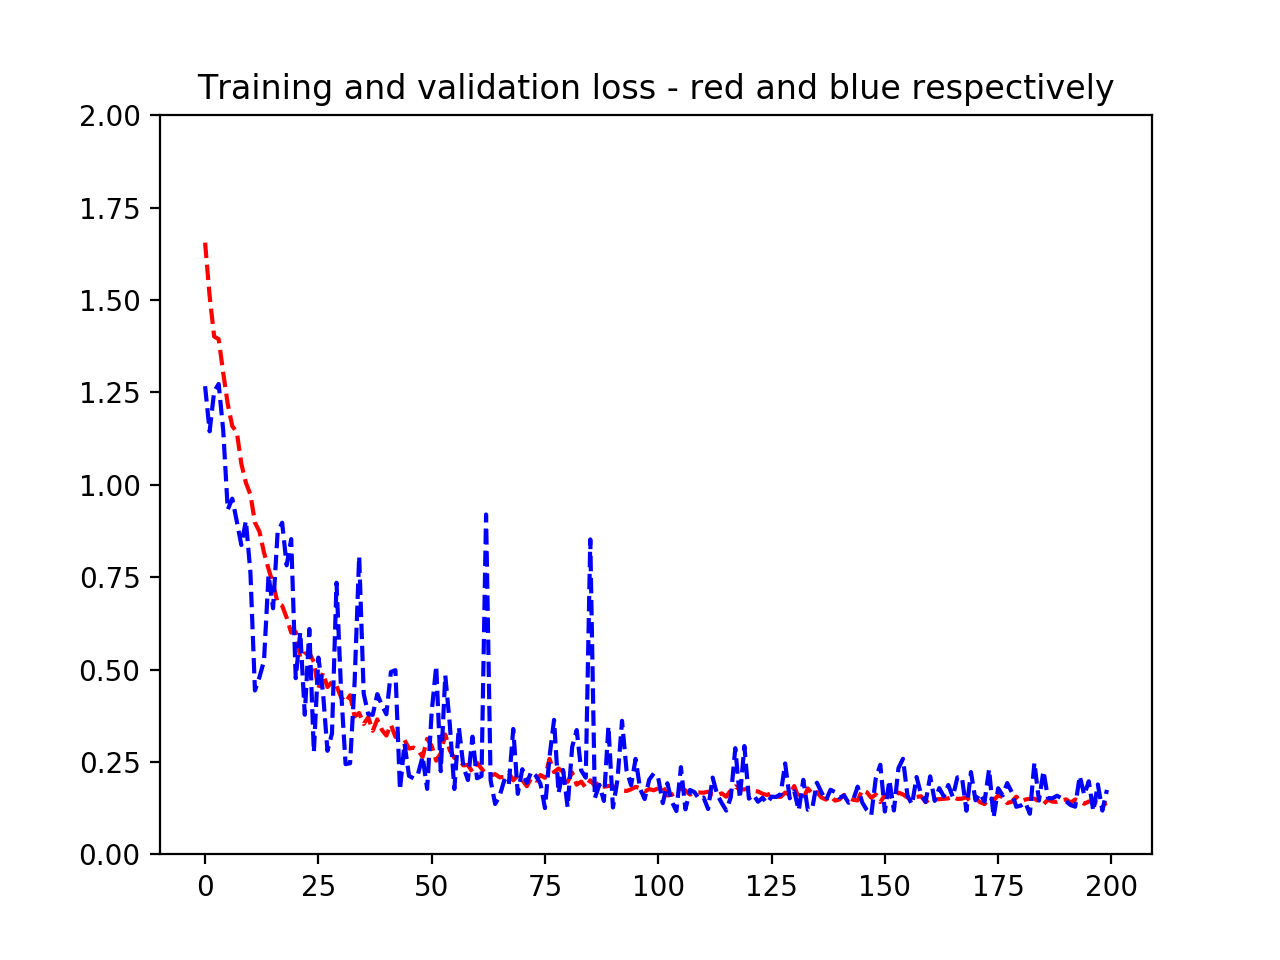

<IPython.core.display.Javascript object>


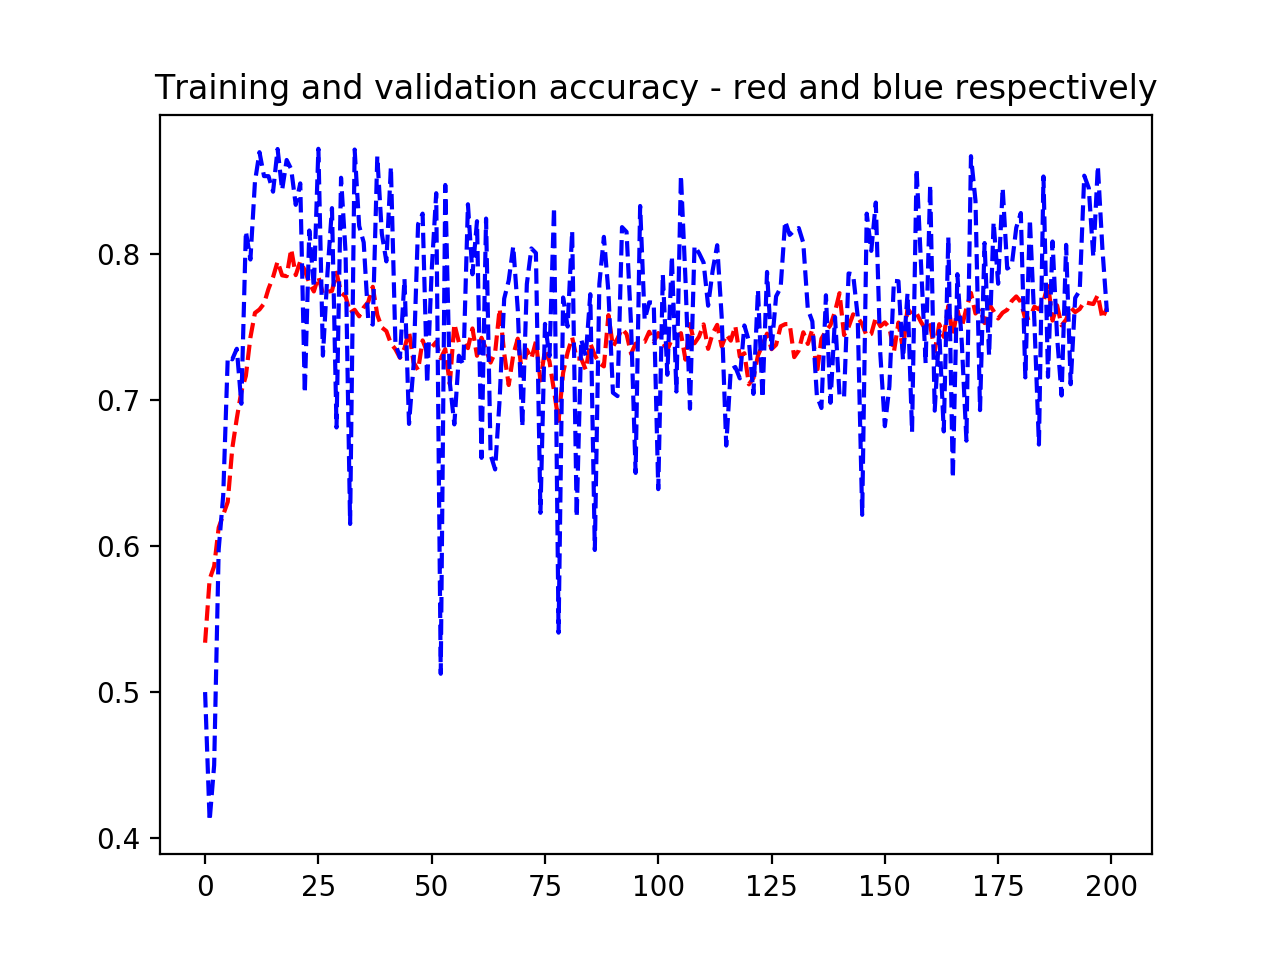

done


In [146]:
saved_dir = '../saved/IMPRS_hdf5_volume_AllDAPI_0701/0701_215654'
config_saved_filename = os.path.join(saved_dir, "config.json")
#os.system('tensorboard --logdir ' + log_dir) cannot use with google VM without paying $$$
viewTraining.graphLoss(saved_dir, best=False) #imported from utils

print('done')

In [147]:
def main2(config, resume):
    # setup data_loader instances
    data_loader = get_instance(module_data, 'data_loader_test', config)
    '''
    
    data_loader = getattr(module_data, config['data_loader']['type'])(
        config['data_loader']['args']['data_dir'],
        batch_size=1,
        shuffle=False,
        validation_split=0.0,
        training=False,
        num_workers=2
    )
    '''
    # build model architecture
    model = get_instance(module_arch, 'arch', config)
    #print(model)
    print(torch.cuda.get_device_name(0))
    normalized = False

    
    # get function handles of loss and metrics
    loss_fn = getattr(module_loss, config['loss'])
    criterion = loss_fn(None)
    metric_fns = [getattr(module_metric, met) for met in config['metrics']]
    
    # load state dict
    checkpoint = torch.load(resume)
    state_dict = checkpoint['state_dict'] #dictionary of model parameters from saved file
    if config['n_gpu'] > 1:
        model = torch.nn.DataParallel(model)
    model.load_state_dict(state_dict) 
    
    # prepare model for testing
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    model.eval() #tells model to ignore dropout and batch normalization
    
    total_loss = 0.0
    total_metrics = torch.zeros(len(metric_fns))
    
    #classes = ('endothelium', 'pct', 'vasculature')
    classes = ('endothelium', 'pct')
    all_pred = []
    all_true = []
    #hm_layers = {'final_layer': 'layer', 'fc_layer': 'fc_layer', 'conv_num': 17, 'fc_num': 3}
    
    #heatmapper = classActivationMap.CAMgenerator(hm_layers, config, model)
    #heatmapper.generateImage(num_images=10)
    
    with torch.no_grad(): #speed up calculations, unable to perform back propogation
        for i, (data, target) in enumerate(tqdm(data_loader)): #tqdm is a progress bar
            data, target = data.to(device), target.to(device)
            output = model(data)
            image = np.squeeze(data[0].cpu().data.numpy())
            label = np.squeeze(target[0].cpu().data.numpy())
            all_true.extend(target.cpu().data.numpy())
            all_pred.extend(np.argmax(output.cpu().data.numpy(), axis=1))
            
            #
            # save sample images, or do something with output here
            #
            
            
            if i < 2:
                m = torch.nn.Softmax()
                print("prediction percentages")
                print(m(output.cpu()[0]))
                print(all_true[i])
                #util.visualizationOutGray(data, output, target, classes, normalized)
                a=1
                
                
                
            # computing loss, metrics on test set
            loss = criterion(output, target)
            batch_size = data.shape[0]
            total_loss += loss.item() * batch_size
            if output.is_cuda: output = output.cpu()
            if target.is_cuda: target = target.cpu()
            
            for i, metric in enumerate(metric_fns):
                total_metrics[i] += metric(output, target) * batch_size
        
        #plt.show()
        
    
    n_samples = len(data_loader.sampler)
    print("num test images = " + str(n_samples))
    log = {'loss': total_loss / n_samples}
    log.update({met.__name__: total_metrics[i].item() / n_samples for i, met in enumerate(metric_fns)})
    for key in log:
        print("{} = {:.4f}".format(key, log[key]))
    #print(log)
    log['classes'] = classes
    log['test_targets'] = all_true
    log['test_predictions'] = all_pred
    print("My_metric is accuracy")
    util.plot_confusion_matrix(all_true, all_pred, classes=classes, normalize=False) 
    


In [148]:
#saved_dir = "saved/GroundTruth_cellData/0529_191042/"
resume = os.path.join(saved_dir, "model_best.pth")

print(os.path.isdir(saved_dir))
print(os.path.exists(resume))

#config = torch.load(saved_dir + "config.json")
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"

True
True


  0%|          | 0/10 [00:00<?, ?it/s]

Tesla K80


/home/awoloshu/miniconda3/envs/pytorch36/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
 20%|██        | 2/10 [00:00<00:01,  5.93it/s]

prediction percentages
tensor([0.0058, 0.9942])
1
prediction percentages
tensor([0.2666, 0.7334])
1


100%|██████████| 10/10 [00:00<00:00, 10.50it/s]

num test images = 605
loss = 0.3705
my_metric = 0.8909
f1 = 0.9154
balanced_accuracy = 0.8923
precision = 0.9720
recall = 0.8909
My_metric is accuracy
Confusion matrix, without normalization
[[ 76  58]
 [  8 463]]


<IPython.core.display.Javascript object>


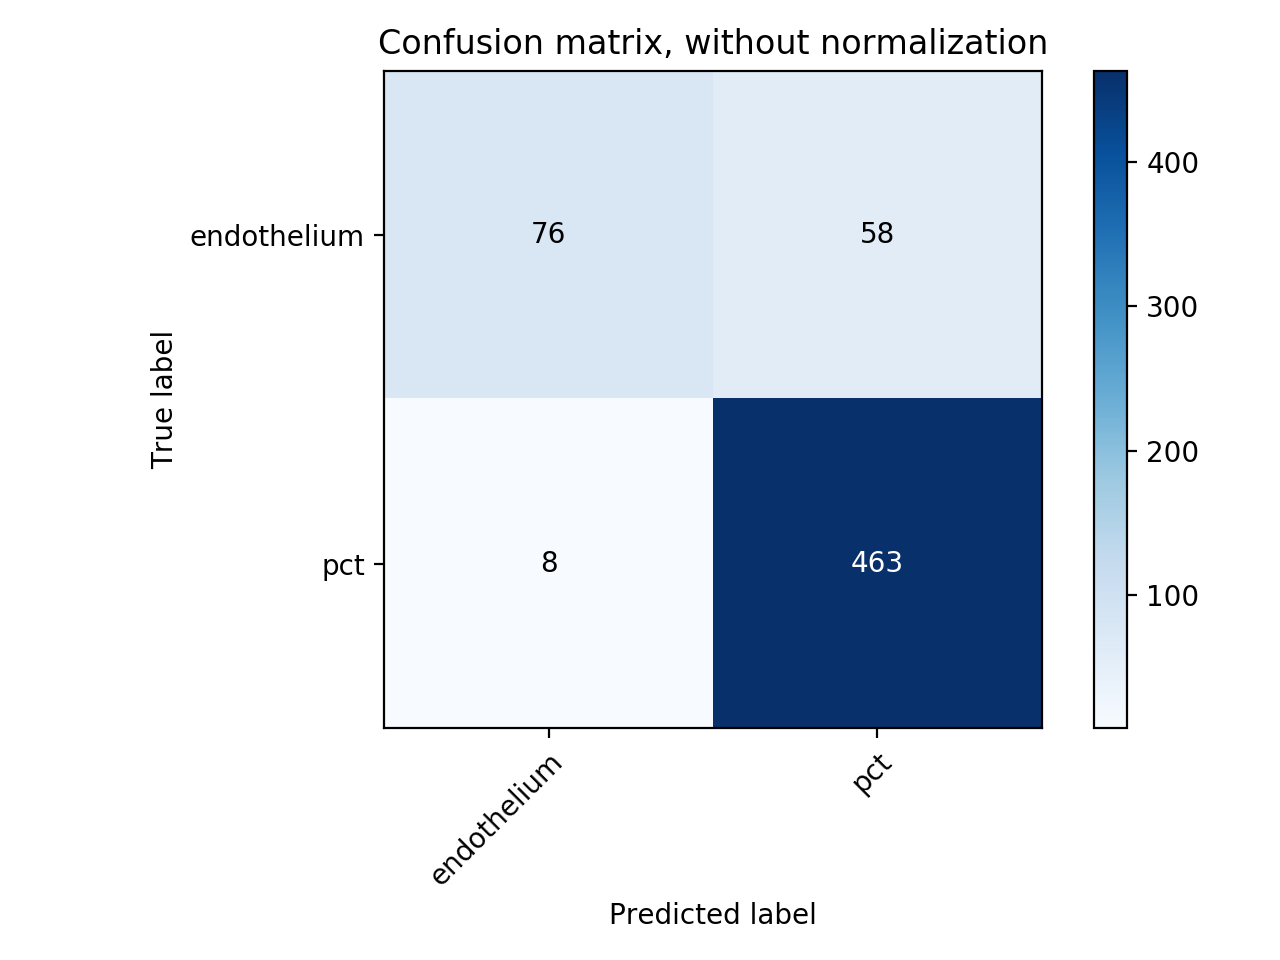

In [149]:
#Test
main2(config, resume)
